# 2 Differential Vision Transformer


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, Subset
from tqdm import tqdm
import os
import cv2
import copy
import torch.optim as optim
import random, math

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 2.1 Tasks


### 1. Differential Attention Implementation

In [3]:
class DifferentialAttention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, attn_drop=0., proj_drop=0., lambda_init=0.5):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5

        self.q1 = nn.Linear(dim, dim, bias=qkv_bias)
        self.k1 = nn.Linear(dim, dim, bias=qkv_bias)
        self.v = nn.Linear(dim, dim, bias=qkv_bias)

        self.q2 = nn.Linear(dim, dim, bias=qkv_bias)
        self.k2 = nn.Linear(dim, dim, bias=qkv_bias)
        
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

        self.lambda_init = lambda_init
        self.lambda_param = nn.Parameter(torch.ones(1) * lambda_init)
        self.attention = None
    
    def forward(self, x):
        B, N, C = x.shape

        q1 = self.q1(x).reshape(B, N, self.num_heads, C // self.num_heads).permute(0, 2, 1, 3)  # B, h, N, d_head
        k1 = self.k1(x).reshape(B, N, self.num_heads, C // self.num_heads).permute(0, 2, 1, 3)  # B, h, N, d_head
        v = self.v(x).reshape(B, N, self.num_heads, C // self.num_heads).permute(0, 2, 1, 3)    # B, h, N, d_head
        
        q2 = self.q2(x).reshape(B, N, self.num_heads, C // self.num_heads).permute(0, 2, 1, 3)  # B, h, N, d_head
        k2 = self.k2(x).reshape(B, N, self.num_heads, C // self.num_heads).permute(0, 2, 1, 3)  # B, h, N, d_head
        
        attn1 = (q1 @ k1.transpose(-2, -1)) * self.scale
        attn1 = F.softmax(attn1, dim=-1)
        attn1 = self.attn_drop(attn1)
        
        attn2 = (q2 @ k2.transpose(-2, -1)) * self.scale
        attn2 = F.softmax(attn2, dim=-1)
        attn2 = self.attn_drop(attn2)

        lambda_val = torch.clamp(self.lambda_param, 0, 1)
        diff_attn = attn1 - lambda_val * attn2

        self.attention = diff_attn.detach()
        x = (diff_attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        
        return x

In [4]:
class MLP(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

In [5]:
class DiffTransformerBlock(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, drop=0., attn_drop=0.,
                 lambda_init=0.5, norm_layer=nn.LayerNorm):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = DifferentialAttention(
            dim, num_heads=num_heads, qkv_bias=qkv_bias, attn_drop=attn_drop, proj_drop=drop,
            lambda_init=lambda_init)
        
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = MLP(in_features=dim, hidden_features=mlp_hidden_dim, drop=drop)
        
    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

### 2. Integrate Differential Attention into ViT

In [6]:
class DiffViT(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_chans=3, num_classes=10, embed_dim=192,num_layers=12, num_heads=8, mlp_ratio=4, qkv_bias=True, drop_rate=0.1, lambda_init=0.5,representation_size=None,pos_embed_type='1d_learned',use_pos_embed=True):
        super().__init__()
        self.num_classes = num_classes
        self.embed_dim = embed_dim
        self.num_layers = num_layers
        self.patch_size = patch_size
        self.img_size = img_size
        self.use_pos_embed = use_pos_embed
        self.pos_embed_type = pos_embed_type
        
        self.patch_embed = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.num_patches = (img_size // patch_size) ** 2

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        if self.use_pos_embed:
            if pos_embed_type == '1d_learned':
                self.pos_embed = nn.Parameter(torch.zeros(1, self.num_patches + 1, embed_dim))
            elif pos_embed_type == '2d_learned':
                h = w = img_size // patch_size
                self.pos_embed_2d = nn.Parameter(torch.zeros(1, embed_dim, h, w))
                self.register_buffer('pos_embed', None)
            elif pos_embed_type == 'sinusoidal':
                self.register_buffer('pos_embed', self._create_sinusoidal_embedding(self.num_patches + 1, embed_dim))
            elif pos_embed_type == 'none':
                self.register_buffer('pos_embed', torch.zeros(1, self.num_patches + 1, embed_dim))
        
        self.pos_drop = nn.Dropout(p=drop_rate)
        self.blocks = nn.ModuleList([
            DiffTransformerBlock(
                dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias,
                drop=drop_rate, attn_drop=drop_rate, lambda_init=lambda_init, norm_layer=nn.LayerNorm)
            for _ in range(num_layers)
        ])
        
        self.norm = nn.LayerNorm(embed_dim)
        if representation_size:
            self.head = nn.Sequential(
                nn.Linear(embed_dim, representation_size),
                nn.Tanh(),
                nn.Linear(representation_size, num_classes)
            )
        else:
            self.head = nn.Linear(embed_dim, num_classes)

    def _create_sinusoidal_embedding(self, length, dim):
        position = torch.arange(length).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, dim, 2) * -(math.log(10000.0) / dim))
        pe = torch.zeros(1, length, dim)
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        return pe

    def _calculate_2d_positional_embedding(self, x):
        B, _, D = x.shape
        H = W = int(math.sqrt(self.num_patches))
        patch_embeddings = x[:, 1:, :].reshape(B, H, W, D).permute(0, 3, 1, 2)  # [B, D, H, W]
        pos_embed = self.pos_embed_2d.expand(B, -1, -1, -1)
        patch_embeddings = patch_embeddings + pos_embed
        patch_embeddings = patch_embeddings.permute(0, 2, 3, 1).reshape(B, self.num_patches, D)
        return torch.cat((x[:, 0:1, :], patch_embeddings), dim=1)

    def forward(self, x, return_attention=False):
        B = x.shape[0]

        x = self.patch_embed(x)
        x = x.flatten(2).transpose(1, 2)

        cls_token = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_token, x), dim=1)

        if self.use_pos_embed:
            if self.pos_embed_type == '1d_learned':
                x = x + self.pos_embed
            elif self.pos_embed_type == '2d_learned':
                x = self._calculate_2d_positional_embedding(x)
            elif self.pos_embed_type in ['sinusoidal', 'none']:
                x = x + self.pos_embed

        x = self.pos_drop(x)

        if return_attention:
            attentions = []

        for block in self.blocks:
            x = block(x)
            if return_attention:
                attentions.append(block.attn.attention.detach())  

        x = self.norm(x)
        logits = self.head(x[:, 0])

        if return_attention:
            return logits, attentions
        return logits

### 3. Training

In [7]:
def get_dataloaders(batch_size=128, train_transform=None, val_split=0.1, num_workers=4, pin_memory=True, random_seed=42):
    if train_transform is None:
        train_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
        ])
    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

    ])
    
    full_train = torchvision.datasets.CIFAR10(root='./data',train=True,download=True)
    num_train = len(full_train)
    val_size = int(num_train * val_split)
    train_size = num_train - val_size

    g = torch.Generator().manual_seed(random_seed)
    permuted_indices = torch.randperm(num_train, generator=g)

    train_indices = permuted_indices[:train_size].tolist()
    val_indices   = permuted_indices[train_size:].tolist()

    train_dataset = Subset(torchvision.datasets.CIFAR10(root='./data',  train=True,  download=False,  transform=train_transform),train_indices)
    val_dataset = Subset(torchvision.datasets.CIFAR10(root='./data',  train=True,  download=False,  transform=test_transform),val_indices)

    test_dataset = torchvision.datasets.CIFAR10(root='./data',  train=False,  download=True,  transform=test_transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)
    val_loader = DataLoader(val_dataset,batch_size=batch_size,shuffle=False,num_workers=num_workers,pin_memory=pin_memory)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)

    return train_loader, val_loader, test_loader

In [8]:
def plot_loss_curves(train_losses, test_losses, train_accs, test_accs, title=""):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    epochs = range(1, len(train_losses) + 1)

    ax1.plot(epochs, train_losses, 'b-', label='Training Loss')
    ax1.plot(epochs, test_losses, 'r-', label='Validation Loss')
    ax1.set_title(f'Training and Validation Loss {title}')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()

    ax2.plot(epochs, train_accs, 'b-', label='Training Accuracy')
    ax2.plot(epochs, test_accs, 'r-', label='Validation Accuracy')
    ax2.set_title(f'Training and Validation Accuracy {title}')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    
    plt.tight_layout()

In [9]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    progress_bar = tqdm(train_loader, desc="Training")
    for batch_idx, (inputs, targets) in enumerate(progress_bar):
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
        progress_bar.set_postfix({
            'loss': running_loss / (batch_idx + 1),
            'acc': 100. * correct / total
        })
    
    return running_loss / len(train_loader), 100. * correct / total

def evaluate(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        progress_bar = tqdm(test_loader, desc="Testing")
        for batch_idx, (inputs, targets) in enumerate(progress_bar):
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            progress_bar.set_postfix({
                'loss': running_loss / (batch_idx + 1),
                'acc': 100. * correct / total
            })
    
    return running_loss / len(test_loader), 100. * correct / total


def train_model(model, train_loader, test_loader, num_epochs, learning_rate=1e-4):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

    train_losses = []
    test_losses = []
    train_accs = []
    test_accs = []
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        
        test_loss, test_acc = evaluate(model, test_loader, criterion, device)
        test_losses.append(test_loss)
        test_accs.append(test_acc)
        
        
        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {test_loss:.4f} | Val Acc: {test_acc:.2f}%")
        
    return {
        'train_losses': train_losses,
        'val_losses': test_losses,
        'train_accs': train_accs,
        'val_accs': test_accs,
    }

In [14]:
NUM_EPOCHS = 20
LEARNING_RATE = 3e-4
trainloader, valloader, testloader = get_dataloaders()

model = DiffViT().to(device)
result = train_model(model, trainloader, valloader, num_epochs=NUM_EPOCHS, learning_rate=LEARNING_RATE)
test_loss, test_acc = evaluate(model, testloader, nn.CrossEntropyLoss(), device)

100%|██████████| 170M/170M [08:30<00:00, 334kB/s]  



Epoch 1/20


Testing: 100%|██████████| 40/40 [00:02<00:00, 16.33it/s, loss=1.47, acc=46]  


Train Loss: 1.6957 | Train Acc: 36.94%
Val Loss: 1.4686 | Val Acc: 46.04%

Epoch 2/20


Testing: 100%|██████████| 40/40 [00:02<00:00, 16.49it/s, loss=1.23, acc=55.1]


Train Loss: 1.3303 | Train Acc: 51.44%
Val Loss: 1.2256 | Val Acc: 55.14%

Epoch 3/20


Testing: 100%|██████████| 40/40 [00:02<00:00, 16.46it/s, loss=1.09, acc=60.3]


Train Loss: 1.1610 | Train Acc: 57.62%
Val Loss: 1.0926 | Val Acc: 60.30%

Epoch 4/20


Testing: 100%|██████████| 40/40 [00:02<00:00, 16.42it/s, loss=1.02, acc=63.9]


Train Loss: 1.0486 | Train Acc: 62.12%
Val Loss: 1.0218 | Val Acc: 63.90%

Epoch 5/20


Testing: 100%|██████████| 40/40 [00:02<00:00, 16.45it/s, loss=0.958, acc=65.9]


Train Loss: 0.9631 | Train Acc: 65.31%
Val Loss: 0.9575 | Val Acc: 65.94%

Epoch 6/20


Testing: 100%|██████████| 40/40 [00:02<00:00, 16.31it/s, loss=0.955, acc=66.5]


Train Loss: 0.8893 | Train Acc: 68.05%
Val Loss: 0.9550 | Val Acc: 66.50%

Epoch 7/20


Testing: 100%|██████████| 40/40 [00:02<00:00, 16.45it/s, loss=0.861, acc=69.5]


Train Loss: 0.8356 | Train Acc: 70.18%
Val Loss: 0.8607 | Val Acc: 69.54%

Epoch 8/20


Testing: 100%|██████████| 40/40 [00:02<00:00, 16.44it/s, loss=0.878, acc=68.8]


Train Loss: 0.7745 | Train Acc: 72.39%
Val Loss: 0.8782 | Val Acc: 68.76%

Epoch 9/20


Testing: 100%|██████████| 40/40 [00:02<00:00, 16.39it/s, loss=0.87, acc=69.9] 


Train Loss: 0.7331 | Train Acc: 73.72%
Val Loss: 0.8705 | Val Acc: 69.86%

Epoch 10/20


Testing: 100%|██████████| 40/40 [00:02<00:00, 16.43it/s, loss=0.88, acc=69.9] 


Train Loss: 0.6892 | Train Acc: 75.50%
Val Loss: 0.8802 | Val Acc: 69.86%

Epoch 11/20


Testing: 100%|██████████| 40/40 [00:02<00:00, 16.29it/s, loss=0.852, acc=71.3]


Train Loss: 0.6454 | Train Acc: 76.90%
Val Loss: 0.8525 | Val Acc: 71.26%

Epoch 12/20


Testing: 100%|██████████| 40/40 [00:02<00:00, 16.41it/s, loss=0.809, acc=72.1]


Train Loss: 0.6054 | Train Acc: 78.32%
Val Loss: 0.8089 | Val Acc: 72.10%

Epoch 13/20


Testing: 100%|██████████| 40/40 [00:02<00:00, 16.41it/s, loss=0.87, acc=70.5] 


Train Loss: 0.5694 | Train Acc: 79.76%
Val Loss: 0.8697 | Val Acc: 70.50%

Epoch 14/20


Testing: 100%|██████████| 40/40 [00:02<00:00, 16.38it/s, loss=0.952, acc=69.9]


Train Loss: 0.5349 | Train Acc: 80.96%
Val Loss: 0.9521 | Val Acc: 69.90%

Epoch 15/20


Testing: 100%|██████████| 40/40 [00:02<00:00, 16.42it/s, loss=0.869, acc=71.4]


Train Loss: 0.5030 | Train Acc: 82.02%
Val Loss: 0.8687 | Val Acc: 71.38%

Epoch 16/20


Testing: 100%|██████████| 40/40 [00:02<00:00, 16.29it/s, loss=0.83, acc=72.3] 


Train Loss: 0.4643 | Train Acc: 83.25%
Val Loss: 0.8297 | Val Acc: 72.26%

Epoch 17/20


Testing: 100%|██████████| 40/40 [00:02<00:00, 16.36it/s, loss=0.85, acc=72.8] 


Train Loss: 0.4358 | Train Acc: 84.46%
Val Loss: 0.8498 | Val Acc: 72.76%

Epoch 18/20


Testing: 100%|██████████| 40/40 [00:02<00:00, 16.27it/s, loss=0.87, acc=72.7] 


Train Loss: 0.4036 | Train Acc: 85.46%
Val Loss: 0.8702 | Val Acc: 72.68%

Epoch 19/20


Testing: 100%|██████████| 40/40 [00:02<00:00, 16.38it/s, loss=0.866, acc=72.6]


Train Loss: 0.3729 | Train Acc: 86.58%
Val Loss: 0.8656 | Val Acc: 72.62%

Epoch 20/20


Testing: 100%|██████████| 40/40 [00:02<00:00, 16.38it/s, loss=0.963, acc=71.8]


Train Loss: 0.3434 | Train Acc: 87.66%
Val Loss: 0.9629 | Val Acc: 71.80%


Testing: 100%|██████████| 79/79 [00:04<00:00, 16.41it/s, loss=0.945, acc=72]  


(0.9452755021143563, 71.95)

In [ ]:
test_loss, test_acc = evaluate(model, testloader, nn.CrossEntropyLoss(), device)
print(f"Test Loss: {test_loss} | Test Accuracy : {test_acc}")
print(result)

Test Loss: 0.9452755021143563 | Test Accuracy : 71.95
{'train_losses': [1.6956540156494488, 1.3303350108590992, 1.1609670560468326, 1.0486189086328854, 0.9631341638212855, 0.8893004276535728, 0.8356272754344073, 0.7744813244789839, 0.7330721239136024, 0.6891631335866722, 0.645440401848067, 0.6053599608554081, 0.5694095383144238, 0.5349096802317284, 0.5029504050246694, 0.46425780438056047, 0.43580426258796995, 0.40358407532965596, 0.37293354235589504, 0.34344273183325474], 'val_losses': [1.468626281619072, 1.2256410107016564, 1.0926075398921966, 1.0218126639723777, 0.9575485944747925, 0.9549899563193321, 0.860692884027958, 0.8781724080443383, 0.8704688251018524, 0.8801557421684265, 0.8524955928325653, 0.8088785380125045, 0.8697298362851142, 0.9520542427897454, 0.8686867445707321, 0.8296696066856384, 0.8498211368918419, 0.870232567191124, 0.8655793711543083, 0.9628771975636482], 'train_accs': [36.937777777777775, 51.437777777777775, 57.617777777777775, 62.11555555555555, 65.3088888888888

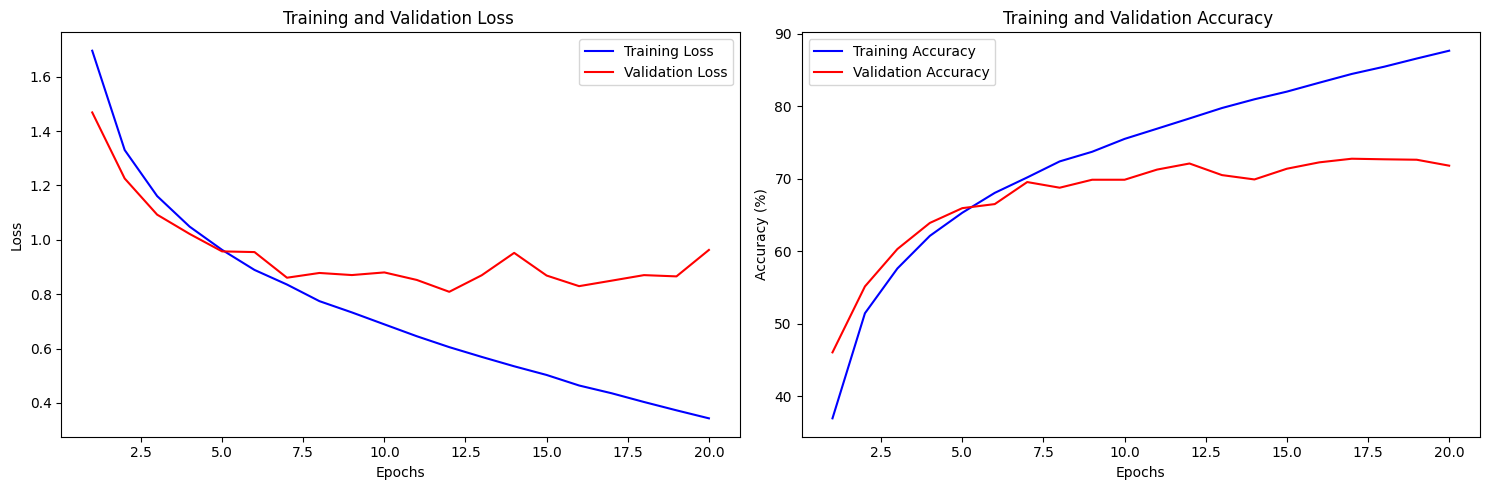

In [10]:
plot_loss_curves(result['train_losses'], result['val_losses'], result['train_accs'], result['val_accs'])

## 2.2 Experiments

### Patch Size

In [ ]:
patch_size = [2, 4]
results = []
test_accs = []
test_losses = []
NUM_EPOCHS = 5
LEARNING_RATE = 3e-4
trainloader, valloader, testloader = get_dataloaders(batch_size=24)

for patchsz in patch_size:
    print(f"Training with patch size: {patchsz}")
    model = DiffViT(patch_size=patchsz).to(device)
    result = train_model(model, trainloader, valloader, num_epochs=NUM_EPOCHS, learning_rate=LEARNING_RATE)
    results.append(result)
    test_loss, test_acc = evaluate(model, testloader, nn.CrossEntropyLoss(), device)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    # print(f"Test Loss: {test_loss} | Test Accuracy : {test_acc}")  


Epoch 1/5


Testing: 100%|██████████| 209/209 [00:15<00:00, 13.39it/s, loss=1.41, acc=48.8]


Train Loss: 1.6468 | Train Acc: 39.16%
Val Loss: 1.4053 | Val Acc: 48.81%

Epoch 2/5


Testing: 100%|██████████| 209/209 [00:15<00:00, 13.35it/s, loss=1.2, acc=56.5] 


Train Loss: 1.3191 | Train Acc: 51.95%
Val Loss: 1.1969 | Val Acc: 56.54%

Epoch 3/5


Testing: 100%|██████████| 209/209 [00:15<00:00, 13.25it/s, loss=1.1, acc=60]   


Train Loss: 1.1534 | Train Acc: 58.10%
Val Loss: 1.1004 | Val Acc: 60.00%

Epoch 4/5


Testing: 100%|██████████| 209/209 [00:15<00:00, 13.24it/s, loss=1, acc=63.9]    


Train Loss: 1.0455 | Train Acc: 62.39%
Val Loss: 1.0040 | Val Acc: 63.85%

Epoch 5/5


Testing: 100%|██████████| 209/209 [00:15<00:00, 13.25it/s, loss=0.937, acc=66.8]


Train Loss: 0.9611 | Train Acc: 65.46%
Val Loss: 0.9368 | Val Acc: 66.78%

Epoch 1/5


Testing: 100%|██████████| 209/209 [00:04<00:00, 46.32it/s, loss=1.34, acc=51.5]


Train Loss: 1.6258 | Train Acc: 39.73%
Val Loss: 1.3385 | Val Acc: 51.53%

Epoch 2/5


Testing: 100%|██████████| 209/209 [00:04<00:00, 48.13it/s, loss=1.17, acc=58]  


Train Loss: 1.2656 | Train Acc: 53.94%
Val Loss: 1.1722 | Val Acc: 57.95%

Epoch 3/5


Testing: 100%|██████████| 209/209 [00:04<00:00, 46.48it/s, loss=1.1, acc=60.1] 


Train Loss: 1.1262 | Train Acc: 59.37%
Val Loss: 1.0975 | Val Acc: 60.08%

Epoch 4/5


Testing: 100%|██████████| 209/209 [00:04<00:00, 49.01it/s, loss=1.01, acc=63.6]


Train Loss: 1.0331 | Train Acc: 62.83%
Val Loss: 1.0138 | Val Acc: 63.60%

Epoch 5/5


Testing: 100%|██████████| 209/209 [00:04<00:00, 46.79it/s, loss=0.967, acc=64.9]

Train Loss: 0.9550 | Train Acc: 65.52%
Val Loss: 0.9666 | Val Acc: 64.89%


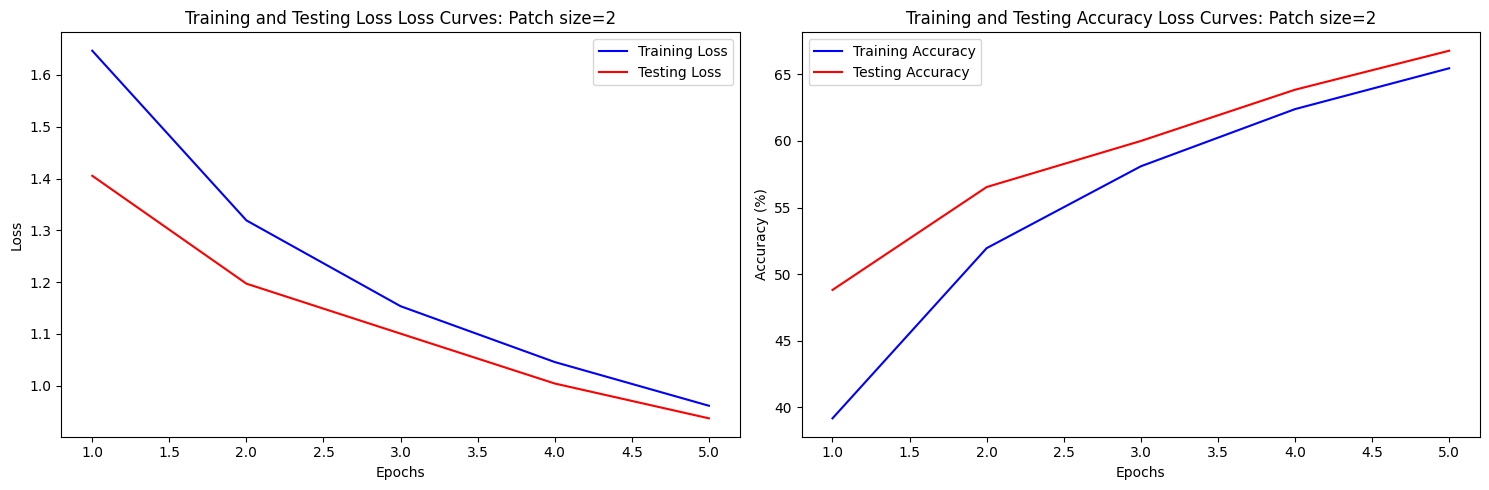

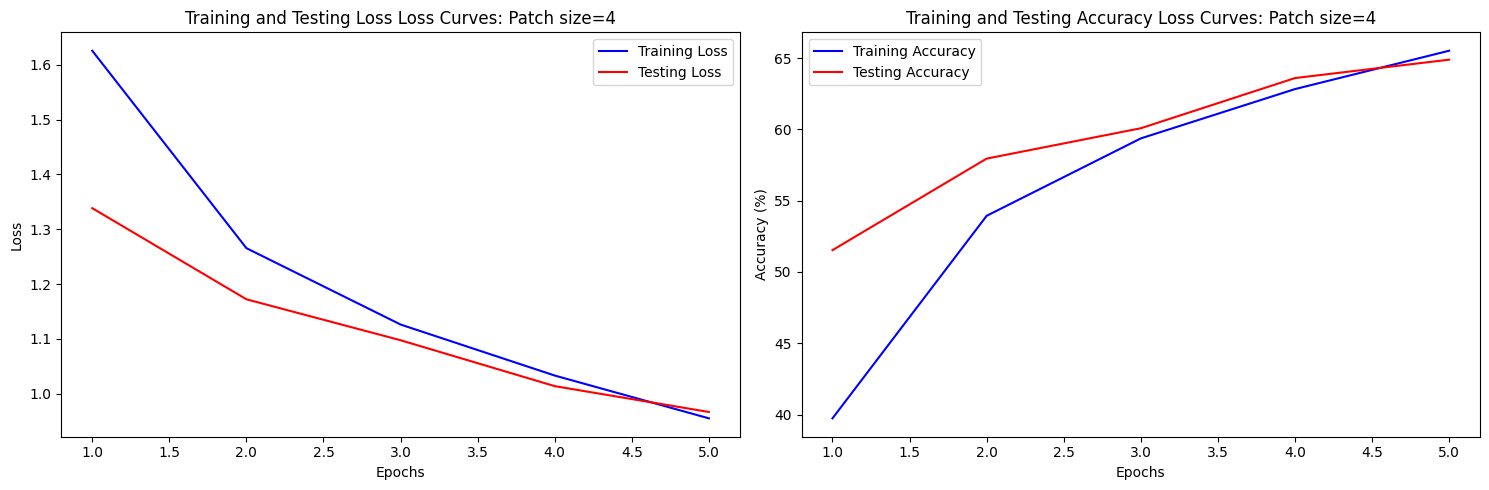

In [ ]:
for result, patchsz in zip(results, patch_size):
    plot_loss_curves(result['train_losses'], result['val_losses'], result['train_accs'], result['val_accs'], title=f"Loss Curves: Patch size={patchsz}")

In [13]:
import pandas as pd
  
data = []
for i, (patchsz, result) in enumerate(zip(patch_size, results)):
    data.append({
        "Patch Size": patchsz,
        "Val Loss": result['val_losses'][-1],
        "Val Accuracy (%)": result['val_accs'][-1],
        "Test Loss": test_losses[i],
        "Test Accuracy (%)": test_accs[i]
    })

df = pd.DataFrame(data)

display(df)

,Patch Size,Val Loss,Val Accuracy (%),Test Loss,Test Accuracy (%)
0,2,1.0040,63.85,0.966847,64.227469
1,4,0.9666,64.89,0.948306,65.077813


### Hyperparameters

In [14]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                            std=[0.2023, 0.1994, 0.2010]),
])

trainloader, testloader = get_dataloaders(train_transform=transform_train)

configurations = [
    {'embed_dim': 256, 'num_layers': 6, 'mlp_ratio': 4, 'num_heads': 8},
    {'embed_dim': 384, 'num_layers': 6, 'mlp_ratio': 2, 'num_heads': 8},
    {'embed_dim': 384, 'num_layers': 8, 'mlp_ratio': 2, 'num_heads': 6},
    {'embed_dim': 512, 'num_layers': 8, 'mlp_ratio': 1, 'num_heads': 8},
]

NUM_EPOCHS = 35
LEARNING_RATE = 3e-4

results = []
test_accs = []
test_losses = []
best_model = None
best_accurs = 0
best_config = None

for config in configurations:
    print(f"Training with config: {config}")
    model = DiffViT(
        embed_dim=config['embed_dim'],
        num_heads=config['num_heads'],
        mlp_ratio=config['mlp_ratio'],
        num_layers=config['num_layers'],
    ).to(device)

    result = train_model(model, trainloader, testloader, num_epochs=NUM_EPOCHS, learning_rate=LEARNING_RATE)
    results.append(result)
    test_loss, test_acc = evaluate(model, testloader, nn.CrossEntropyLoss(), device)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    if test_acc > best_accurs:
        best_accurs = test_acc
        best_model = copy.deepcopy(model)
        best_config = config

    print("-" * 50)


torch.save(best_model.state_dict(), 'checkpoints/diffvit_best.pth')



Training with config: {'embed_dim': 256, 'num_layers': 6, 'mlp_ratio': 4, 'num_heads': 8}

Epoch 1/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 38.63it/s, loss=1.45, acc=46.7]


Train Loss: 1.7199 | Train Acc: 35.71%
Val Loss: 1.4511 | Val Acc: 46.74%

Epoch 2/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 38.26it/s, loss=1.4, acc=50.2] 


Train Loss: 1.3852 | Train Acc: 49.17%
Val Loss: 1.4038 | Val Acc: 50.25%

Epoch 3/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 38.72it/s, loss=1.13, acc=59.3]


Train Loss: 1.2365 | Train Acc: 55.03%
Val Loss: 1.1305 | Val Acc: 59.26%

Epoch 4/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 38.32it/s, loss=1.11, acc=59.8]


Train Loss: 1.1363 | Train Acc: 58.96%
Val Loss: 1.1115 | Val Acc: 59.76%

Epoch 5/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 38.70it/s, loss=0.999, acc=64.2]


Train Loss: 1.0725 | Train Acc: 61.35%
Val Loss: 0.9990 | Val Acc: 64.19%

Epoch 6/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 38.56it/s, loss=1.02, acc=64]  


Train Loss: 1.0101 | Train Acc: 63.81%
Val Loss: 1.0249 | Val Acc: 63.97%

Epoch 7/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 37.95it/s, loss=0.919, acc=66.8]


Train Loss: 0.9689 | Train Acc: 65.28%
Val Loss: 0.9188 | Val Acc: 66.85%

Epoch 8/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 38.43it/s, loss=0.877, acc=68.5]


Train Loss: 0.9204 | Train Acc: 67.03%
Val Loss: 0.8767 | Val Acc: 68.46%

Epoch 9/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 38.21it/s, loss=0.856, acc=69.8]


Train Loss: 0.8828 | Train Acc: 68.50%
Val Loss: 0.8559 | Val Acc: 69.78%

Epoch 10/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 38.47it/s, loss=0.796, acc=71.8]


Train Loss: 0.8476 | Train Acc: 69.98%
Val Loss: 0.7963 | Val Acc: 71.81%

Epoch 11/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 37.82it/s, loss=0.837, acc=70.2]


Train Loss: 0.8209 | Train Acc: 71.10%
Val Loss: 0.8365 | Val Acc: 70.24%

Epoch 12/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 38.06it/s, loss=0.754, acc=73.5]


Train Loss: 0.7887 | Train Acc: 71.98%
Val Loss: 0.7542 | Val Acc: 73.54%

Epoch 13/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 38.59it/s, loss=0.723, acc=74.7]


Train Loss: 0.7662 | Train Acc: 72.94%
Val Loss: 0.7228 | Val Acc: 74.74%

Epoch 14/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 38.93it/s, loss=0.722, acc=74.3]


Train Loss: 0.7436 | Train Acc: 73.56%
Val Loss: 0.7222 | Val Acc: 74.27%

Epoch 15/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 39.06it/s, loss=0.721, acc=74.6]


Train Loss: 0.7220 | Train Acc: 74.35%
Val Loss: 0.7212 | Val Acc: 74.63%

Epoch 16/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 38.73it/s, loss=0.692, acc=76.1]


Train Loss: 0.6970 | Train Acc: 75.26%
Val Loss: 0.6917 | Val Acc: 76.10%

Epoch 17/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 38.37it/s, loss=0.707, acc=74.6]


Train Loss: 0.6731 | Train Acc: 76.20%
Val Loss: 0.7070 | Val Acc: 74.63%

Epoch 18/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 38.83it/s, loss=0.713, acc=75.3]


Train Loss: 0.6595 | Train Acc: 76.75%
Val Loss: 0.7127 | Val Acc: 75.35%

Epoch 19/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 38.20it/s, loss=0.648, acc=77.7]


Train Loss: 0.6366 | Train Acc: 77.40%
Val Loss: 0.6477 | Val Acc: 77.65%

Epoch 20/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 39.11it/s, loss=0.686, acc=76.3]


Train Loss: 0.6287 | Train Acc: 77.66%
Val Loss: 0.6862 | Val Acc: 76.35%

Epoch 21/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 39.13it/s, loss=0.615, acc=78.8]


Train Loss: 0.6151 | Train Acc: 78.21%
Val Loss: 0.6153 | Val Acc: 78.78%

Epoch 22/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 38.71it/s, loss=0.631, acc=78.2]


Train Loss: 0.5939 | Train Acc: 78.96%
Val Loss: 0.6310 | Val Acc: 78.18%

Epoch 23/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 38.07it/s, loss=0.626, acc=78.7]


Train Loss: 0.5857 | Train Acc: 79.39%
Val Loss: 0.6264 | Val Acc: 78.73%

Epoch 24/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 38.62it/s, loss=0.6, acc=79.2]  


Train Loss: 0.5713 | Train Acc: 79.66%
Val Loss: 0.5997 | Val Acc: 79.25%

Epoch 25/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 38.02it/s, loss=0.625, acc=78.3]


Train Loss: 0.5532 | Train Acc: 80.57%
Val Loss: 0.6246 | Val Acc: 78.30%

Epoch 26/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 38.58it/s, loss=0.646, acc=78.1]


Train Loss: 0.5502 | Train Acc: 80.57%
Val Loss: 0.6462 | Val Acc: 78.08%

Epoch 27/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 38.35it/s, loss=0.611, acc=79]  


Train Loss: 0.5322 | Train Acc: 81.08%
Val Loss: 0.6114 | Val Acc: 78.97%

Epoch 28/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 38.86it/s, loss=0.594, acc=80]  


Train Loss: 0.5259 | Train Acc: 81.29%
Val Loss: 0.5944 | Val Acc: 80.01%

Epoch 29/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 39.36it/s, loss=0.602, acc=79.4]


Train Loss: 0.5122 | Train Acc: 81.91%
Val Loss: 0.6023 | Val Acc: 79.38%

Epoch 30/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 37.98it/s, loss=0.59, acc=80.2] 


Train Loss: 0.5054 | Train Acc: 82.25%
Val Loss: 0.5895 | Val Acc: 80.19%

Epoch 31/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 39.16it/s, loss=0.582, acc=80.6]


Train Loss: 0.4943 | Train Acc: 82.31%
Val Loss: 0.5825 | Val Acc: 80.56%

Epoch 32/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 37.68it/s, loss=0.582, acc=80.7]


Train Loss: 0.4789 | Train Acc: 83.07%
Val Loss: 0.5819 | Val Acc: 80.66%

Epoch 33/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 38.23it/s, loss=0.581, acc=80]  


Train Loss: 0.4696 | Train Acc: 83.29%
Val Loss: 0.5807 | Val Acc: 79.95%

Epoch 34/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 38.90it/s, loss=0.587, acc=80.2]


Train Loss: 0.4564 | Train Acc: 83.80%
Val Loss: 0.5874 | Val Acc: 80.17%

Epoch 35/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 38.88it/s, loss=0.583, acc=80.7]


Train Loss: 0.4479 | Train Acc: 84.03%
Val Loss: 0.5832 | Val Acc: 80.70%
--------------------------------------------------
Training with config: {'embed_dim': 384, 'num_layers': 6, 'mlp_ratio': 2, 'num_heads': 8}

Epoch 1/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 31.65it/s, loss=1.41, acc=49.2]


Train Loss: 1.6706 | Train Acc: 38.10%
Val Loss: 1.4065 | Val Acc: 49.19%

Epoch 2/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 31.20it/s, loss=1.24, acc=55.5]


Train Loss: 1.3486 | Train Acc: 50.87%
Val Loss: 1.2359 | Val Acc: 55.50%

Epoch 3/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 31.62it/s, loss=1.12, acc=59.4]


Train Loss: 1.2131 | Train Acc: 56.05%
Val Loss: 1.1155 | Val Acc: 59.44%

Epoch 4/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 32.22it/s, loss=1.08, acc=61.8]


Train Loss: 1.1256 | Train Acc: 59.37%
Val Loss: 1.0843 | Val Acc: 61.82%

Epoch 5/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 31.59it/s, loss=1.02, acc=63.7]


Train Loss: 1.0700 | Train Acc: 61.57%
Val Loss: 1.0193 | Val Acc: 63.72%

Epoch 6/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 32.15it/s, loss=0.965, acc=65.8]


Train Loss: 1.0062 | Train Acc: 64.03%
Val Loss: 0.9652 | Val Acc: 65.79%

Epoch 7/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 32.21it/s, loss=0.914, acc=67.6]


Train Loss: 0.9616 | Train Acc: 65.46%
Val Loss: 0.9144 | Val Acc: 67.56%

Epoch 8/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 31.76it/s, loss=0.867, acc=68.9]


Train Loss: 0.9146 | Train Acc: 67.55%
Val Loss: 0.8670 | Val Acc: 68.93%

Epoch 9/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 32.30it/s, loss=0.841, acc=69.9]


Train Loss: 0.8760 | Train Acc: 68.86%
Val Loss: 0.8408 | Val Acc: 69.91%

Epoch 10/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 31.79it/s, loss=0.811, acc=71.3]


Train Loss: 0.8356 | Train Acc: 70.17%
Val Loss: 0.8115 | Val Acc: 71.28%

Epoch 11/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 32.35it/s, loss=0.752, acc=73.2]


Train Loss: 0.8034 | Train Acc: 71.56%
Val Loss: 0.7516 | Val Acc: 73.25%

Epoch 12/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 32.11it/s, loss=0.782, acc=71.9]


Train Loss: 0.7769 | Train Acc: 72.66%
Val Loss: 0.7824 | Val Acc: 71.87%

Epoch 13/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 31.85it/s, loss=0.71, acc=75.3] 


Train Loss: 0.7506 | Train Acc: 73.28%
Val Loss: 0.7104 | Val Acc: 75.27%

Epoch 14/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 31.94it/s, loss=0.713, acc=74.6]


Train Loss: 0.7296 | Train Acc: 74.37%
Val Loss: 0.7127 | Val Acc: 74.63%

Epoch 15/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 31.28it/s, loss=0.717, acc=74.6]


Train Loss: 0.7039 | Train Acc: 75.05%
Val Loss: 0.7167 | Val Acc: 74.61%

Epoch 16/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 32.06it/s, loss=0.677, acc=76.4]


Train Loss: 0.6868 | Train Acc: 75.67%
Val Loss: 0.6770 | Val Acc: 76.44%

Epoch 17/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 31.28it/s, loss=0.678, acc=76]  


Train Loss: 0.6641 | Train Acc: 76.61%
Val Loss: 0.6785 | Val Acc: 75.95%

Epoch 18/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 32.11it/s, loss=0.637, acc=77.6]


Train Loss: 0.6459 | Train Acc: 77.06%
Val Loss: 0.6372 | Val Acc: 77.59%

Epoch 19/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 31.69it/s, loss=0.635, acc=77.6]


Train Loss: 0.6228 | Train Acc: 77.97%
Val Loss: 0.6348 | Val Acc: 77.63%

Epoch 20/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 31.13it/s, loss=0.672, acc=76.9]


Train Loss: 0.6087 | Train Acc: 78.36%
Val Loss: 0.6716 | Val Acc: 76.92%

Epoch 21/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 31.69it/s, loss=0.607, acc=79.4]


Train Loss: 0.5982 | Train Acc: 78.92%
Val Loss: 0.6067 | Val Acc: 79.37%

Epoch 22/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 31.67it/s, loss=0.63, acc=78.1] 


Train Loss: 0.5825 | Train Acc: 79.27%
Val Loss: 0.6303 | Val Acc: 78.12%

Epoch 23/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 31.65it/s, loss=0.595, acc=79.2]


Train Loss: 0.5668 | Train Acc: 79.93%
Val Loss: 0.5954 | Val Acc: 79.18%

Epoch 24/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 31.65it/s, loss=0.593, acc=79.7]


Train Loss: 0.5526 | Train Acc: 80.55%
Val Loss: 0.5926 | Val Acc: 79.70%

Epoch 25/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 31.57it/s, loss=0.592, acc=79.6]


Train Loss: 0.5372 | Train Acc: 81.03%
Val Loss: 0.5922 | Val Acc: 79.60%

Epoch 26/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 31.60it/s, loss=0.577, acc=80]  


Train Loss: 0.5291 | Train Acc: 81.19%
Val Loss: 0.5771 | Val Acc: 79.96%

Epoch 27/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 32.10it/s, loss=0.577, acc=80]  


Train Loss: 0.5140 | Train Acc: 81.81%
Val Loss: 0.5774 | Val Acc: 80.02%

Epoch 28/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 32.11it/s, loss=0.59, acc=79.9] 


Train Loss: 0.5050 | Train Acc: 82.28%
Val Loss: 0.5900 | Val Acc: 79.92%

Epoch 29/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 31.70it/s, loss=0.595, acc=79.6]


Train Loss: 0.4898 | Train Acc: 82.66%
Val Loss: 0.5950 | Val Acc: 79.56%

Epoch 30/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 31.74it/s, loss=0.57, acc=80.7] 


Train Loss: 0.4818 | Train Acc: 82.84%
Val Loss: 0.5697 | Val Acc: 80.68%

Epoch 31/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 31.31it/s, loss=0.57, acc=80.8] 


Train Loss: 0.4715 | Train Acc: 83.29%
Val Loss: 0.5701 | Val Acc: 80.80%

Epoch 32/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 31.93it/s, loss=0.552, acc=81.1]


Train Loss: 0.4609 | Train Acc: 83.56%
Val Loss: 0.5517 | Val Acc: 81.09%

Epoch 33/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 31.27it/s, loss=0.566, acc=80.8]


Train Loss: 0.4550 | Train Acc: 83.82%
Val Loss: 0.5657 | Val Acc: 80.84%

Epoch 34/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 31.46it/s, loss=0.559, acc=81.5]


Train Loss: 0.4410 | Train Acc: 84.32%
Val Loss: 0.5592 | Val Acc: 81.47%

Epoch 35/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 31.95it/s, loss=0.552, acc=81.5]


Train Loss: 0.4319 | Train Acc: 84.62%
Val Loss: 0.5517 | Val Acc: 81.52%
--------------------------------------------------
Training with config: {'embed_dim': 384, 'num_layers': 8, 'mlp_ratio': 2, 'num_heads': 6}

Epoch 1/35


Testing: 100%|██████████| 79/79 [00:03<00:00, 26.17it/s, loss=1.5, acc=45.2] 


Train Loss: 1.7175 | Train Acc: 36.30%
Val Loss: 1.5007 | Val Acc: 45.25%

Epoch 2/35


Testing: 100%|██████████| 79/79 [00:03<00:00, 25.99it/s, loss=1.32, acc=52.8]


Train Loss: 1.3794 | Train Acc: 49.73%
Val Loss: 1.3204 | Val Acc: 52.80%

Epoch 3/35


Testing: 100%|██████████| 79/79 [00:03<00:00, 26.02it/s, loss=1.14, acc=59.1]


Train Loss: 1.2351 | Train Acc: 55.23%
Val Loss: 1.1405 | Val Acc: 59.10%

Epoch 4/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 26.39it/s, loss=1.08, acc=61.4]


Train Loss: 1.1446 | Train Acc: 58.62%
Val Loss: 1.0823 | Val Acc: 61.38%

Epoch 5/35


Testing: 100%|██████████| 79/79 [00:03<00:00, 26.18it/s, loss=1.02, acc=63.4]


Train Loss: 1.0831 | Train Acc: 60.93%
Val Loss: 1.0195 | Val Acc: 63.44%

Epoch 6/35


Testing: 100%|██████████| 79/79 [00:03<00:00, 25.85it/s, loss=0.97, acc=65.5] 


Train Loss: 1.0266 | Train Acc: 62.96%
Val Loss: 0.9698 | Val Acc: 65.53%

Epoch 7/35


Testing: 100%|██████████| 79/79 [00:03<00:00, 26.29it/s, loss=0.944, acc=66.5]


Train Loss: 0.9793 | Train Acc: 64.61%
Val Loss: 0.9436 | Val Acc: 66.46%

Epoch 8/35


Testing: 100%|██████████| 79/79 [00:03<00:00, 26.03it/s, loss=0.898, acc=68.2]


Train Loss: 0.9420 | Train Acc: 66.40%
Val Loss: 0.8984 | Val Acc: 68.18%

Epoch 9/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 26.35it/s, loss=0.866, acc=68]  


Train Loss: 0.9042 | Train Acc: 67.62%
Val Loss: 0.8660 | Val Acc: 68.02%

Epoch 10/35


Testing: 100%|██████████| 79/79 [00:03<00:00, 26.18it/s, loss=0.831, acc=70.3]


Train Loss: 0.8676 | Train Acc: 69.21%
Val Loss: 0.8310 | Val Acc: 70.30%

Epoch 11/35


Testing: 100%|██████████| 79/79 [00:03<00:00, 26.16it/s, loss=0.818, acc=70.9]


Train Loss: 0.8287 | Train Acc: 70.59%
Val Loss: 0.8176 | Val Acc: 70.89%

Epoch 12/35


Testing: 100%|██████████| 79/79 [00:03<00:00, 26.18it/s, loss=0.802, acc=71.5]


Train Loss: 0.8033 | Train Acc: 71.31%
Val Loss: 0.8022 | Val Acc: 71.46%

Epoch 13/35


Testing: 100%|██████████| 79/79 [00:03<00:00, 25.94it/s, loss=0.769, acc=72.5]


Train Loss: 0.7814 | Train Acc: 72.05%
Val Loss: 0.7686 | Val Acc: 72.48%

Epoch 14/35


Testing: 100%|██████████| 79/79 [00:03<00:00, 26.15it/s, loss=0.699, acc=75.9]


Train Loss: 0.7526 | Train Acc: 73.36%
Val Loss: 0.6987 | Val Acc: 75.88%

Epoch 15/35


Testing: 100%|██████████| 79/79 [00:03<00:00, 25.98it/s, loss=0.704, acc=75.9]


Train Loss: 0.7246 | Train Acc: 74.37%
Val Loss: 0.7038 | Val Acc: 75.92%

Epoch 16/35


Testing: 100%|██████████| 79/79 [00:03<00:00, 25.89it/s, loss=0.683, acc=75.9]


Train Loss: 0.7148 | Train Acc: 74.41%
Val Loss: 0.6829 | Val Acc: 75.91%

Epoch 17/35


Testing: 100%|██████████| 79/79 [00:03<00:00, 25.90it/s, loss=0.686, acc=76.3]


Train Loss: 0.6929 | Train Acc: 75.55%
Val Loss: 0.6858 | Val Acc: 76.26%

Epoch 18/35


Testing: 100%|██████████| 79/79 [00:03<00:00, 25.72it/s, loss=0.65, acc=77]   


Train Loss: 0.6676 | Train Acc: 76.44%
Val Loss: 0.6500 | Val Acc: 77.01%

Epoch 19/35


Testing: 100%|██████████| 79/79 [00:03<00:00, 25.91it/s, loss=0.646, acc=77.5]


Train Loss: 0.6553 | Train Acc: 76.84%
Val Loss: 0.6457 | Val Acc: 77.54%

Epoch 20/35


Testing: 100%|██████████| 79/79 [00:03<00:00, 25.99it/s, loss=0.67, acc=76.7] 


Train Loss: 0.6376 | Train Acc: 77.35%
Val Loss: 0.6702 | Val Acc: 76.74%

Epoch 21/35


Testing: 100%|██████████| 79/79 [00:03<00:00, 26.28it/s, loss=0.661, acc=76.9]


Train Loss: 0.6206 | Train Acc: 78.16%
Val Loss: 0.6615 | Val Acc: 76.94%

Epoch 22/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 26.59it/s, loss=0.619, acc=78.5]


Train Loss: 0.6021 | Train Acc: 78.64%
Val Loss: 0.6188 | Val Acc: 78.50%

Epoch 23/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 26.46it/s, loss=0.615, acc=79]  


Train Loss: 0.5889 | Train Acc: 79.26%
Val Loss: 0.6153 | Val Acc: 78.96%

Epoch 24/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 26.37it/s, loss=0.588, acc=79.2]


Train Loss: 0.5753 | Train Acc: 79.43%
Val Loss: 0.5881 | Val Acc: 79.20%

Epoch 25/35


Testing: 100%|██████████| 79/79 [00:03<00:00, 26.25it/s, loss=0.587, acc=80.4]


Train Loss: 0.5633 | Train Acc: 79.94%
Val Loss: 0.5872 | Val Acc: 80.37%

Epoch 26/35


Testing: 100%|██████████| 79/79 [00:03<00:00, 25.61it/s, loss=0.594, acc=79.4]


Train Loss: 0.5478 | Train Acc: 80.55%
Val Loss: 0.5945 | Val Acc: 79.41%

Epoch 27/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 26.48it/s, loss=0.579, acc=80.5]


Train Loss: 0.5390 | Train Acc: 80.81%
Val Loss: 0.5789 | Val Acc: 80.45%

Epoch 28/35


Testing: 100%|██████████| 79/79 [00:03<00:00, 26.25it/s, loss=0.559, acc=80.5]


Train Loss: 0.5283 | Train Acc: 81.12%
Val Loss: 0.5594 | Val Acc: 80.53%

Epoch 29/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 26.43it/s, loss=0.565, acc=80.6]


Train Loss: 0.5105 | Train Acc: 82.00%
Val Loss: 0.5652 | Val Acc: 80.61%

Epoch 30/35


Testing: 100%|██████████| 79/79 [00:03<00:00, 26.01it/s, loss=0.57, acc=80.4] 


Train Loss: 0.5090 | Train Acc: 81.91%
Val Loss: 0.5701 | Val Acc: 80.38%

Epoch 31/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 26.51it/s, loss=0.569, acc=80.5]


Train Loss: 0.4915 | Train Acc: 82.59%
Val Loss: 0.5693 | Val Acc: 80.51%

Epoch 32/35


Testing: 100%|██████████| 79/79 [00:03<00:00, 25.95it/s, loss=0.558, acc=80.5]


Train Loss: 0.4858 | Train Acc: 82.85%
Val Loss: 0.5576 | Val Acc: 80.55%

Epoch 33/35


Testing: 100%|██████████| 79/79 [00:03<00:00, 26.28it/s, loss=0.585, acc=80.1]


Train Loss: 0.4738 | Train Acc: 83.29%
Val Loss: 0.5852 | Val Acc: 80.06%

Epoch 34/35


Testing: 100%|██████████| 79/79 [00:03<00:00, 26.26it/s, loss=0.546, acc=81.8]


Train Loss: 0.4618 | Train Acc: 83.65%
Val Loss: 0.5456 | Val Acc: 81.76%

Epoch 35/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 26.42it/s, loss=0.567, acc=80.6]


Train Loss: 0.4564 | Train Acc: 83.64%
Val Loss: 0.5669 | Val Acc: 80.60%
--------------------------------------------------
Training with config: {'embed_dim': 512, 'num_layers': 8, 'mlp_ratio': 1, 'num_heads': 8}

Epoch 1/35


Testing: 100%|██████████| 79/79 [00:03<00:00, 20.26it/s, loss=1.49, acc=46]  


Train Loss: 1.7032 | Train Acc: 36.76%
Val Loss: 1.4900 | Val Acc: 45.98%

Epoch 2/35


Testing: 100%|██████████| 79/79 [00:03<00:00, 20.16it/s, loss=1.25, acc=54.9]


Train Loss: 1.3620 | Train Acc: 50.40%
Val Loss: 1.2530 | Val Acc: 54.90%

Epoch 3/35


Testing: 100%|██████████| 79/79 [00:03<00:00, 20.19it/s, loss=1.15, acc=58.8]


Train Loss: 1.2330 | Train Acc: 55.16%
Val Loss: 1.1491 | Val Acc: 58.81%

Epoch 4/35


Testing: 100%|██████████| 79/79 [00:03<00:00, 20.13it/s, loss=1.07, acc=61.6]


Train Loss: 1.1463 | Train Acc: 58.67%
Val Loss: 1.0748 | Val Acc: 61.64%

Epoch 5/35


Testing: 100%|██████████| 79/79 [00:03<00:00, 20.19it/s, loss=0.989, acc=64.4]


Train Loss: 1.0801 | Train Acc: 61.13%
Val Loss: 0.9888 | Val Acc: 64.37%

Epoch 6/35


Testing: 100%|██████████| 79/79 [00:03<00:00, 20.16it/s, loss=1.02, acc=64.2]


Train Loss: 1.0292 | Train Acc: 62.97%
Val Loss: 1.0229 | Val Acc: 64.17%

Epoch 7/35


Testing: 100%|██████████| 79/79 [00:03<00:00, 20.09it/s, loss=0.96, acc=65.2] 


Train Loss: 0.9807 | Train Acc: 64.81%
Val Loss: 0.9602 | Val Acc: 65.25%

Epoch 8/35


Testing: 100%|██████████| 79/79 [00:03<00:00, 20.16it/s, loss=0.882, acc=68.4]


Train Loss: 0.9380 | Train Acc: 66.43%
Val Loss: 0.8820 | Val Acc: 68.41%

Epoch 9/35


Testing: 100%|██████████| 79/79 [00:03<00:00, 20.27it/s, loss=0.86, acc=69.6] 


Train Loss: 0.9022 | Train Acc: 67.77%
Val Loss: 0.8605 | Val Acc: 69.62%

Epoch 10/35


Testing: 100%|██████████| 79/79 [00:03<00:00, 20.20it/s, loss=0.811, acc=71.3]


Train Loss: 0.8680 | Train Acc: 69.09%
Val Loss: 0.8111 | Val Acc: 71.30%

Epoch 11/35


Testing: 100%|██████████| 79/79 [00:03<00:00, 20.09it/s, loss=0.788, acc=71.7]


Train Loss: 0.8372 | Train Acc: 70.14%
Val Loss: 0.7878 | Val Acc: 71.74%

Epoch 12/35


Testing: 100%|██████████| 79/79 [00:03<00:00, 20.29it/s, loss=0.763, acc=72.9]


Train Loss: 0.8146 | Train Acc: 71.01%
Val Loss: 0.7632 | Val Acc: 72.91%

Epoch 13/35


Testing: 100%|██████████| 79/79 [00:03<00:00, 20.15it/s, loss=0.747, acc=73.5]


Train Loss: 0.7767 | Train Acc: 72.30%
Val Loss: 0.7474 | Val Acc: 73.54%

Epoch 14/35


Testing: 100%|██████████| 79/79 [00:03<00:00, 20.24it/s, loss=0.743, acc=73.7]


Train Loss: 0.7591 | Train Acc: 73.21%
Val Loss: 0.7434 | Val Acc: 73.66%

Epoch 15/35


Testing: 100%|██████████| 79/79 [00:03<00:00, 20.12it/s, loss=0.713, acc=74.4]


Train Loss: 0.7317 | Train Acc: 73.92%
Val Loss: 0.7128 | Val Acc: 74.38%

Epoch 16/35


Testing: 100%|██████████| 79/79 [00:03<00:00, 20.32it/s, loss=0.722, acc=74.3]


Train Loss: 0.7141 | Train Acc: 74.76%
Val Loss: 0.7222 | Val Acc: 74.35%

Epoch 17/35


Testing: 100%|██████████| 79/79 [00:03<00:00, 20.32it/s, loss=0.677, acc=76.4]


Train Loss: 0.6906 | Train Acc: 75.45%
Val Loss: 0.6770 | Val Acc: 76.37%

Epoch 18/35


Testing: 100%|██████████| 79/79 [00:03<00:00, 20.25it/s, loss=0.673, acc=76.2]


Train Loss: 0.6747 | Train Acc: 76.31%
Val Loss: 0.6728 | Val Acc: 76.23%

Epoch 19/35


Testing: 100%|██████████| 79/79 [00:03<00:00, 20.08it/s, loss=0.646, acc=77.1]


Train Loss: 0.6605 | Train Acc: 76.50%
Val Loss: 0.6465 | Val Acc: 77.07%

Epoch 20/35


Testing: 100%|██████████| 79/79 [00:03<00:00, 19.94it/s, loss=0.646, acc=77.3]


Train Loss: 0.6348 | Train Acc: 77.55%
Val Loss: 0.6463 | Val Acc: 77.33%

Epoch 21/35


Testing: 100%|██████████| 79/79 [00:03<00:00, 20.19it/s, loss=0.657, acc=77.1]


Train Loss: 0.6216 | Train Acc: 78.06%
Val Loss: 0.6566 | Val Acc: 77.11%

Epoch 22/35


Testing: 100%|██████████| 79/79 [00:03<00:00, 20.23it/s, loss=0.63, acc=78]   


Train Loss: 0.6093 | Train Acc: 78.42%
Val Loss: 0.6299 | Val Acc: 77.99%

Epoch 23/35


Testing: 100%|██████████| 79/79 [00:03<00:00, 20.20it/s, loss=0.641, acc=77.7]


Train Loss: 0.5956 | Train Acc: 78.87%
Val Loss: 0.6414 | Val Acc: 77.71%

Epoch 24/35


Testing: 100%|██████████| 79/79 [00:03<00:00, 20.36it/s, loss=0.627, acc=78.3]


Train Loss: 0.5810 | Train Acc: 79.45%
Val Loss: 0.6266 | Val Acc: 78.31%

Epoch 25/35


Testing: 100%|██████████| 79/79 [00:03<00:00, 20.24it/s, loss=0.589, acc=79.4]


Train Loss: 0.5729 | Train Acc: 79.85%
Val Loss: 0.5892 | Val Acc: 79.39%

Epoch 26/35


Testing: 100%|██████████| 79/79 [00:03<00:00, 20.33it/s, loss=0.613, acc=78.7]


Train Loss: 0.5584 | Train Acc: 80.40%
Val Loss: 0.6135 | Val Acc: 78.66%

Epoch 27/35


Testing: 100%|██████████| 79/79 [00:03<00:00, 20.30it/s, loss=0.582, acc=80.2]


Train Loss: 0.5406 | Train Acc: 80.82%
Val Loss: 0.5824 | Val Acc: 80.15%

Epoch 28/35


Testing: 100%|██████████| 79/79 [00:03<00:00, 20.42it/s, loss=0.591, acc=79.8]


Train Loss: 0.5325 | Train Acc: 81.16%
Val Loss: 0.5911 | Val Acc: 79.81%

Epoch 29/35


Testing: 100%|██████████| 79/79 [00:03<00:00, 20.27it/s, loss=0.589, acc=79]  


Train Loss: 0.5192 | Train Acc: 81.66%
Val Loss: 0.5885 | Val Acc: 78.99%

Epoch 30/35


Testing: 100%|██████████| 79/79 [00:03<00:00, 20.20it/s, loss=0.584, acc=79.9]


Train Loss: 0.5058 | Train Acc: 82.13%
Val Loss: 0.5842 | Val Acc: 79.89%

Epoch 31/35


Testing: 100%|██████████| 79/79 [00:03<00:00, 20.25it/s, loss=0.555, acc=81]  


Train Loss: 0.5029 | Train Acc: 82.29%
Val Loss: 0.5555 | Val Acc: 81.01%

Epoch 32/35


Testing: 100%|██████████| 79/79 [00:03<00:00, 20.19it/s, loss=0.599, acc=79.4]


Train Loss: 0.4896 | Train Acc: 82.65%
Val Loss: 0.5990 | Val Acc: 79.43%

Epoch 33/35


Testing: 100%|██████████| 79/79 [00:03<00:00, 20.42it/s, loss=0.567, acc=80.8]


Train Loss: 0.4816 | Train Acc: 82.91%
Val Loss: 0.5667 | Val Acc: 80.78%

Epoch 34/35


Testing: 100%|██████████| 79/79 [00:03<00:00, 20.26it/s, loss=0.548, acc=81.4]


Train Loss: 0.4724 | Train Acc: 83.36%
Val Loss: 0.5479 | Val Acc: 81.42%

Epoch 35/35


Testing: 100%|██████████| 79/79 [00:03<00:00, 20.31it/s, loss=0.588, acc=80.7]


Train Loss: 0.4575 | Train Acc: 83.81%
Val Loss: 0.5877 | Val Acc: 80.69%
--------------------------------------------------


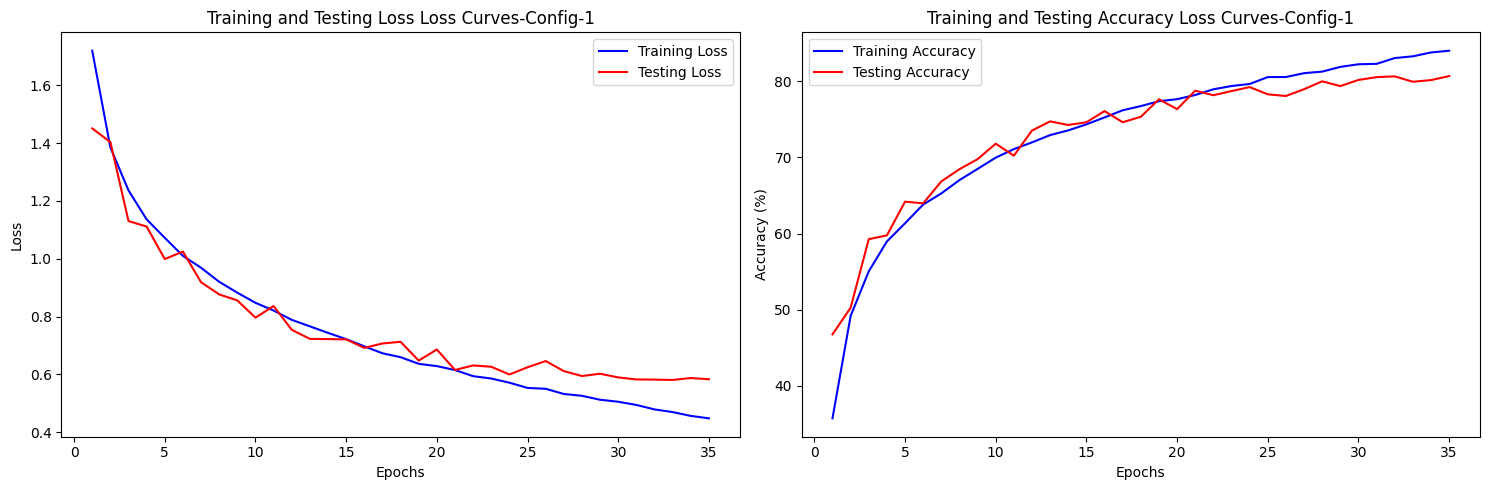

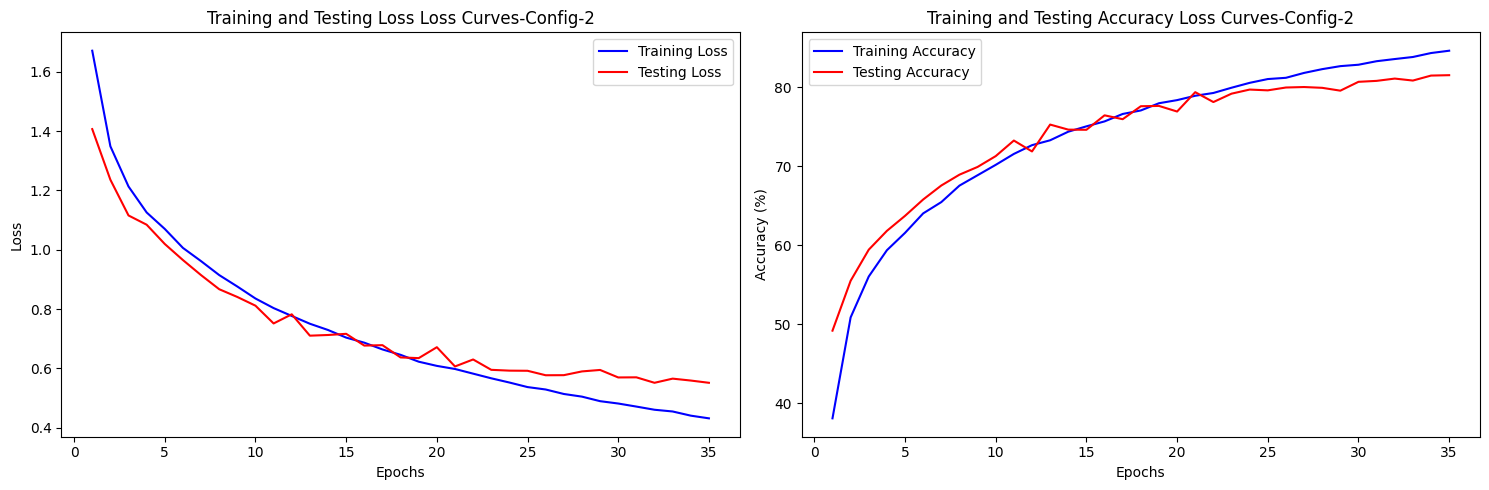

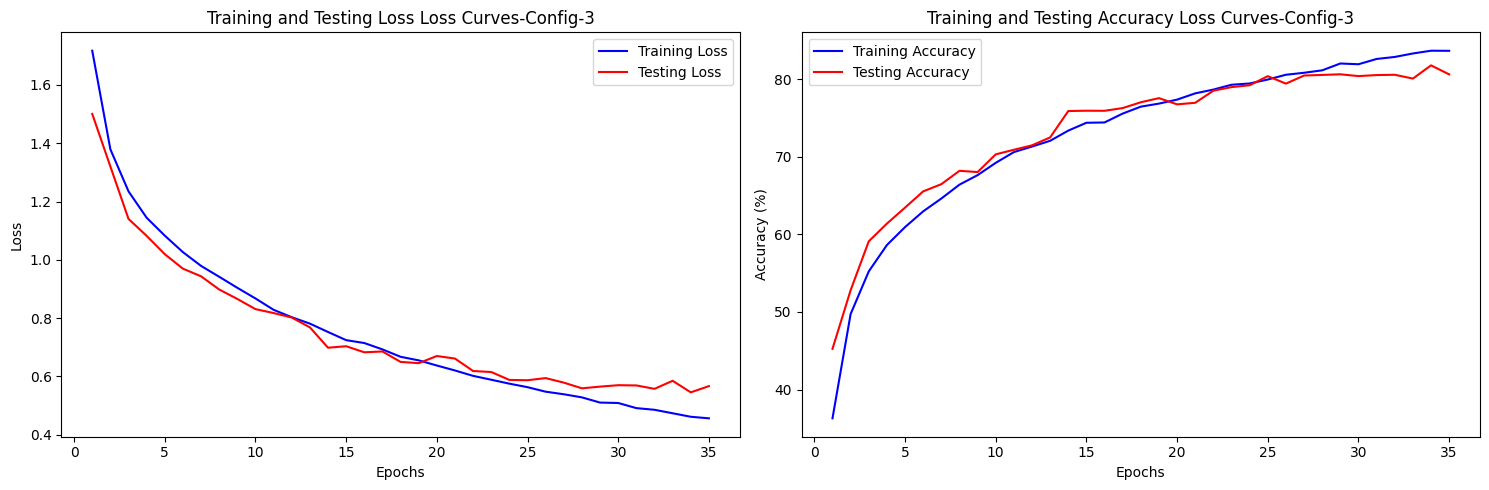

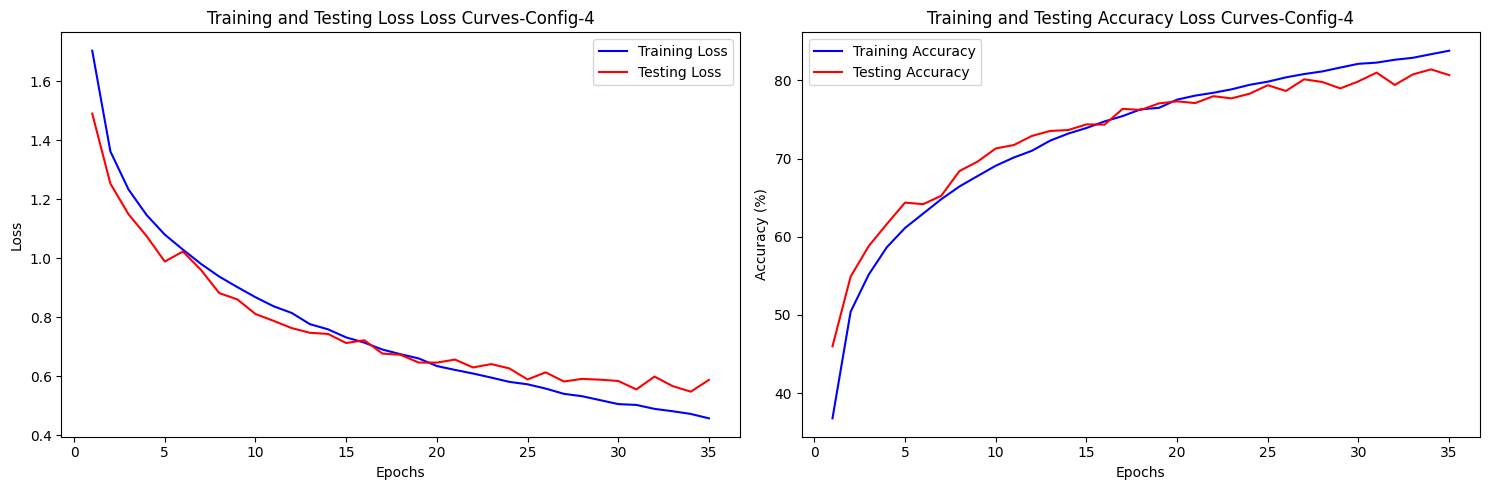

In [14]:
for i, (config, result) in enumerate(zip(config, results)):
    plot_loss_curves(result['train_losses'], result['test_losses'], result['train_accs'], result['test_accs'], title=f"Loss Curves-Config-{i + 1}")

In [ ]:
for i, (config, result) in enumerate(zip(configurations, results)):
    print(f"For Config : {config}:")
    print(f"Test Accuracy : {test_accs[i]}")

print(f"\nBest Configuration: {best_config}")

For Config : {'embed_dim': 256, 'num_layers': 6, 'mlp_ratio': 4, 'num_heads': 8}:
Test Accuracy : 80.7
For Config : {'embed_dim': 384, 'num_layers': 6, 'mlp_ratio': 2, 'num_heads': 8}:
Test Accuracy : 81.52
For Config : {'embed_dim': 384, 'num_layers': 8, 'mlp_ratio': 2, 'num_heads': 6}:
Test Accuracy : 80.6
For Config : {'embed_dim': 512, 'num_layers': 8, 'mlp_ratio': 1, 'num_heads': 8}:
Test Accuracy : 80.69

Best Configuration: {'embed_dim': 384, 'num_layers': 6, 'mlp_ratio': 2, 'num_heads': 8}


### Data augmentation

In [27]:
transform1 = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

transform2 = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandAugment(num_ops=2, magnitude=9),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

transform3 = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandAugment(num_ops=2, magnitude=9),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    transforms.RandomErasing(p=0.25, scale=(0.02, 0.2), ratio=(0.3, 3.3), value=0),
])

NUM_EPOCHS = 35
augmentation = [transform1, transform2, transform3]
results = []
test_accs = []
test_losses = []    

for augs in augmentation:
    print(f"\n\nTraining with augmentation: {augs}")
    trainloader, valloader, testloader = get_dataloaders(train_transform=augs)
    model = DiffViT(
        embed_dim=best_config['embed_dim'],
        num_heads=best_config['num_heads'],
        mlp_ratio=best_config['mlp_ratio'],
        num_layers=best_config['num_layers'],
    ).to(device)
    result = train_model(model, trainloader, valloader, num_epochs=NUM_EPOCHS, learning_rate=LEARNING_RATE)
    results.append(result)
    
    test_loss, test_acc = evaluate(model, testloader, nn.CrossEntropyLoss(), device)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    print("__" * 50)
    print(_)
    print(f"Test Loss: {test_loss} | Test Accuracy : {test_acc}")  
    print("__" * 50)



Training with augmentation: Compose(
    RandomHorizontalFlip(p=0.5)
    RandomCrop(size=(32, 32), padding=4)
    ToTensor()
    Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
)

Epoch 1/35


Testing: 100%|██████████| 40/40 [00:02<00:00, 17.41it/s, loss=1.42, acc=48.4]


Train Loss: 1.7116 | Train Acc: 36.48%
Val Loss: 1.4212 | Val Acc: 48.40%

Epoch 2/35


Testing: 100%|██████████| 40/40 [00:02<00:00, 17.44it/s, loss=1.29, acc=53.2]


Train Loss: 1.3680 | Train Acc: 50.34%
Val Loss: 1.2908 | Val Acc: 53.16%

Epoch 3/35


Testing: 100%|██████████| 40/40 [00:02<00:00, 17.44it/s, loss=1.17, acc=57.6]


Train Loss: 1.2277 | Train Acc: 55.52%
Val Loss: 1.1713 | Val Acc: 57.64%

Epoch 4/35


Testing: 100%|██████████| 40/40 [00:02<00:00, 17.54it/s, loss=1.07, acc=60.9]


Train Loss: 1.1415 | Train Acc: 58.88%
Val Loss: 1.0678 | Val Acc: 60.92%

Epoch 5/35


Testing: 100%|██████████| 40/40 [00:02<00:00, 17.48it/s, loss=0.996, acc=63.7]


Train Loss: 1.0722 | Train Acc: 61.37%
Val Loss: 0.9958 | Val Acc: 63.72%

Epoch 6/35


Testing: 100%|██████████| 40/40 [00:02<00:00, 17.38it/s, loss=0.931, acc=66.4]


Train Loss: 1.0199 | Train Acc: 63.43%
Val Loss: 0.9314 | Val Acc: 66.38%

Epoch 7/35


Testing: 100%|██████████| 40/40 [00:02<00:00, 17.40it/s, loss=0.919, acc=67]  


Train Loss: 0.9788 | Train Acc: 64.88%
Val Loss: 0.9187 | Val Acc: 67.00%

Epoch 8/35


Testing: 100%|██████████| 40/40 [00:02<00:00, 17.40it/s, loss=0.873, acc=68.5]


Train Loss: 0.9328 | Train Acc: 66.65%
Val Loss: 0.8730 | Val Acc: 68.54%

Epoch 9/35


Testing: 100%|██████████| 40/40 [00:02<00:00, 17.36it/s, loss=0.869, acc=69.1]


Train Loss: 0.8994 | Train Acc: 67.87%
Val Loss: 0.8690 | Val Acc: 69.14%

Epoch 10/35


Testing: 100%|██████████| 40/40 [00:02<00:00, 17.42it/s, loss=0.843, acc=70.3]


Train Loss: 0.8621 | Train Acc: 69.32%
Val Loss: 0.8428 | Val Acc: 70.34%

Epoch 11/35


Testing: 100%|██████████| 40/40 [00:02<00:00, 17.41it/s, loss=0.781, acc=72.3]


Train Loss: 0.8418 | Train Acc: 70.05%
Val Loss: 0.7805 | Val Acc: 72.26%

Epoch 12/35


Testing: 100%|██████████| 40/40 [00:02<00:00, 17.46it/s, loss=0.795, acc=71.8]


Train Loss: 0.8019 | Train Acc: 71.28%
Val Loss: 0.7946 | Val Acc: 71.76%

Epoch 13/35


Testing: 100%|██████████| 40/40 [00:02<00:00, 17.34it/s, loss=0.779, acc=73.4]


Train Loss: 0.7865 | Train Acc: 72.17%
Val Loss: 0.7794 | Val Acc: 73.44%

Epoch 14/35


Testing: 100%|██████████| 40/40 [00:02<00:00, 17.38it/s, loss=0.749, acc=73.7]


Train Loss: 0.7601 | Train Acc: 73.22%
Val Loss: 0.7486 | Val Acc: 73.72%

Epoch 15/35


Testing: 100%|██████████| 40/40 [00:02<00:00, 17.36it/s, loss=0.708, acc=75.9]


Train Loss: 0.7302 | Train Acc: 74.14%
Val Loss: 0.7084 | Val Acc: 75.94%

Epoch 16/35


Testing: 100%|██████████| 40/40 [00:02<00:00, 17.41it/s, loss=0.713, acc=75.7]


Train Loss: 0.7154 | Train Acc: 74.64%
Val Loss: 0.7135 | Val Acc: 75.66%

Epoch 17/35


Testing: 100%|██████████| 40/40 [00:02<00:00, 17.49it/s, loss=0.692, acc=75.9]


Train Loss: 0.6949 | Train Acc: 75.40%
Val Loss: 0.6920 | Val Acc: 75.86%

Epoch 18/35


Testing: 100%|██████████| 40/40 [00:02<00:00, 17.36it/s, loss=0.727, acc=75.2]


Train Loss: 0.6764 | Train Acc: 75.98%
Val Loss: 0.7273 | Val Acc: 75.24%

Epoch 19/35


Testing: 100%|██████████| 40/40 [00:02<00:00, 17.52it/s, loss=0.689, acc=75.4]


Train Loss: 0.6635 | Train Acc: 76.32%
Val Loss: 0.6886 | Val Acc: 75.44%

Epoch 20/35


Testing: 100%|██████████| 40/40 [00:02<00:00, 17.40it/s, loss=0.685, acc=76.5]


Train Loss: 0.6364 | Train Acc: 77.30%
Val Loss: 0.6845 | Val Acc: 76.46%

Epoch 21/35


Testing: 100%|██████████| 40/40 [00:02<00:00, 17.46it/s, loss=0.66, acc=76.6] 


Train Loss: 0.6294 | Train Acc: 77.70%
Val Loss: 0.6596 | Val Acc: 76.58%

Epoch 22/35


Testing: 100%|██████████| 40/40 [00:02<00:00, 17.47it/s, loss=0.68, acc=76.9] 


Train Loss: 0.6067 | Train Acc: 78.64%
Val Loss: 0.6801 | Val Acc: 76.90%

Epoch 23/35


Testing: 100%|██████████| 40/40 [00:02<00:00, 17.39it/s, loss=0.667, acc=76.8]


Train Loss: 0.5912 | Train Acc: 79.16%
Val Loss: 0.6673 | Val Acc: 76.80%

Epoch 24/35


Testing: 100%|██████████| 40/40 [00:02<00:00, 17.40it/s, loss=0.646, acc=77.2]


Train Loss: 0.5824 | Train Acc: 79.34%
Val Loss: 0.6461 | Val Acc: 77.22%

Epoch 25/35


Testing: 100%|██████████| 40/40 [00:02<00:00, 17.51it/s, loss=0.616, acc=78.6]


Train Loss: 0.5629 | Train Acc: 80.07%
Val Loss: 0.6161 | Val Acc: 78.58%

Epoch 26/35


Testing: 100%|██████████| 40/40 [00:02<00:00, 17.41it/s, loss=0.642, acc=78.2]


Train Loss: 0.5556 | Train Acc: 80.33%
Val Loss: 0.6422 | Val Acc: 78.24%

Epoch 27/35


Testing: 100%|██████████| 40/40 [00:02<00:00, 17.55it/s, loss=0.636, acc=77.7]


Train Loss: 0.5456 | Train Acc: 80.60%
Val Loss: 0.6361 | Val Acc: 77.74%

Epoch 28/35


Testing: 100%|██████████| 40/40 [00:02<00:00, 17.48it/s, loss=0.615, acc=79.1]


Train Loss: 0.5246 | Train Acc: 81.37%
Val Loss: 0.6152 | Val Acc: 79.12%

Epoch 29/35


Testing: 100%|██████████| 40/40 [00:02<00:00, 17.29it/s, loss=0.597, acc=79.9]


Train Loss: 0.5228 | Train Acc: 81.47%
Val Loss: 0.5969 | Val Acc: 79.86%

Epoch 30/35


Testing: 100%|██████████| 40/40 [00:02<00:00, 17.37it/s, loss=0.614, acc=79.2]


Train Loss: 0.5065 | Train Acc: 82.06%
Val Loss: 0.6140 | Val Acc: 79.16%

Epoch 31/35


Testing: 100%|██████████| 40/40 [00:02<00:00, 17.41it/s, loss=0.611, acc=79.6]


Train Loss: 0.4937 | Train Acc: 82.43%
Val Loss: 0.6112 | Val Acc: 79.62%

Epoch 32/35


Testing: 100%|██████████| 40/40 [00:02<00:00, 17.31it/s, loss=0.617, acc=79.1]


Train Loss: 0.4818 | Train Acc: 82.96%
Val Loss: 0.6175 | Val Acc: 79.12%

Epoch 33/35


Testing: 100%|██████████| 40/40 [00:02<00:00, 17.40it/s, loss=0.595, acc=79.8]


Train Loss: 0.4736 | Train Acc: 83.08%
Val Loss: 0.5950 | Val Acc: 79.78%

Epoch 34/35


Testing: 100%|██████████| 40/40 [00:02<00:00, 17.41it/s, loss=0.609, acc=80.3]


Train Loss: 0.4671 | Train Acc: 83.38%
Val Loss: 0.6086 | Val Acc: 80.28%

Epoch 35/35


Testing: 100%|██████████| 40/40 [00:02<00:00, 17.35it/s, loss=0.593, acc=80.3]


Train Loss: 0.4536 | Train Acc: 83.92%
Val Loss: 0.5927 | Val Acc: 80.28%


Testing: 100%|██████████| 79/79 [00:04<00:00, 17.51it/s, loss=0.604, acc=80]  


____________________________________________________________________________________________________

Test Loss: 0.6044446324245839 | Test Accuracy : 79.98
____________________________________________________________________________________________________


Training with augmentation: Compose(
    RandomHorizontalFlip(p=0.5)
    RandAugment(num_ops=2, magnitude=9, num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    RandomCrop(size=(32, 32), padding=4)
    ToTensor()
    Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
)

Epoch 1/35


Testing: 100%|██████████| 40/40 [00:02<00:00, 17.46it/s, loss=1.59, acc=40.3]


Train Loss: 1.8705 | Train Acc: 30.26%
Val Loss: 1.5887 | Val Acc: 40.34%

Epoch 2/35


Testing: 100%|██████████| 40/40 [00:02<00:00, 17.43it/s, loss=1.33, acc=52]  


Train Loss: 1.5572 | Train Acc: 43.34%
Val Loss: 1.3279 | Val Acc: 51.98%

Epoch 3/35


Testing: 100%|██████████| 40/40 [00:02<00:00, 17.50it/s, loss=1.14, acc=57.2]


Train Loss: 1.4314 | Train Acc: 48.03%
Val Loss: 1.1431 | Val Acc: 57.24%

Epoch 4/35


Testing: 100%|██████████| 40/40 [00:02<00:00, 17.47it/s, loss=1.11, acc=58.9]


Train Loss: 1.3482 | Train Acc: 51.36%
Val Loss: 1.1124 | Val Acc: 58.86%

Epoch 5/35


Testing: 100%|██████████| 40/40 [00:02<00:00, 17.42it/s, loss=1.05, acc=61.4]


Train Loss: 1.2873 | Train Acc: 53.93%
Val Loss: 1.0485 | Val Acc: 61.44%

Epoch 6/35


Testing: 100%|██████████| 40/40 [00:02<00:00, 17.47it/s, loss=1.04, acc=62.7]


Train Loss: 1.2336 | Train Acc: 55.74%
Val Loss: 1.0399 | Val Acc: 62.70%

Epoch 7/35


Testing: 100%|██████████| 40/40 [00:02<00:00, 17.39it/s, loss=0.99, acc=64.2] 


Train Loss: 1.1885 | Train Acc: 57.48%
Val Loss: 0.9903 | Val Acc: 64.18%

Epoch 8/35


Testing: 100%|██████████| 40/40 [00:02<00:00, 17.45it/s, loss=0.926, acc=66.6]


Train Loss: 1.1551 | Train Acc: 58.62%
Val Loss: 0.9257 | Val Acc: 66.56%

Epoch 9/35


Testing: 100%|██████████| 40/40 [00:02<00:00, 17.47it/s, loss=0.925, acc=65.8]


Train Loss: 1.1165 | Train Acc: 59.97%
Val Loss: 0.9251 | Val Acc: 65.78%

Epoch 10/35


Testing: 100%|██████████| 40/40 [00:02<00:00, 17.50it/s, loss=0.867, acc=68]  


Train Loss: 1.0817 | Train Acc: 61.18%
Val Loss: 0.8670 | Val Acc: 67.98%

Epoch 11/35


Testing: 100%|██████████| 40/40 [00:02<00:00, 17.46it/s, loss=0.852, acc=69.5]


Train Loss: 1.0538 | Train Acc: 62.44%
Val Loss: 0.8524 | Val Acc: 69.50%

Epoch 12/35


Testing: 100%|██████████| 40/40 [00:02<00:00, 17.38it/s, loss=0.837, acc=69.8]


Train Loss: 1.0169 | Train Acc: 64.00%
Val Loss: 0.8369 | Val Acc: 69.84%

Epoch 13/35


Testing: 100%|██████████| 40/40 [00:02<00:00, 17.44it/s, loss=0.808, acc=70.9]


Train Loss: 0.9910 | Train Acc: 64.57%
Val Loss: 0.8079 | Val Acc: 70.88%

Epoch 14/35


Testing: 100%|██████████| 40/40 [00:02<00:00, 17.44it/s, loss=0.778, acc=72]  


Train Loss: 0.9690 | Train Acc: 65.75%
Val Loss: 0.7776 | Val Acc: 72.00%

Epoch 15/35


Testing: 100%|██████████| 40/40 [00:02<00:00, 17.42it/s, loss=0.743, acc=73.3]


Train Loss: 0.9439 | Train Acc: 66.51%
Val Loss: 0.7426 | Val Acc: 73.28%

Epoch 16/35


Testing: 100%|██████████| 40/40 [00:02<00:00, 17.44it/s, loss=0.745, acc=73.5]


Train Loss: 0.9298 | Train Acc: 67.13%
Val Loss: 0.7448 | Val Acc: 73.48%

Epoch 17/35


Testing: 100%|██████████| 40/40 [00:02<00:00, 17.46it/s, loss=0.739, acc=73.3]


Train Loss: 0.9002 | Train Acc: 68.39%
Val Loss: 0.7394 | Val Acc: 73.28%

Epoch 18/35


Testing: 100%|██████████| 40/40 [00:02<00:00, 17.37it/s, loss=0.72, acc=74.8] 


Train Loss: 0.8901 | Train Acc: 68.48%
Val Loss: 0.7197 | Val Acc: 74.76%

Epoch 19/35


Testing: 100%|██████████| 40/40 [00:02<00:00, 17.42it/s, loss=0.698, acc=75.5]


Train Loss: 0.8673 | Train Acc: 69.20%
Val Loss: 0.6980 | Val Acc: 75.48%

Epoch 20/35


Testing: 100%|██████████| 40/40 [00:02<00:00, 17.38it/s, loss=0.706, acc=74.8]


Train Loss: 0.8580 | Train Acc: 69.81%
Val Loss: 0.7059 | Val Acc: 74.80%

Epoch 21/35


Testing: 100%|██████████| 40/40 [00:02<00:00, 17.23it/s, loss=0.69, acc=75]   


Train Loss: 0.8412 | Train Acc: 70.30%
Val Loss: 0.6897 | Val Acc: 75.04%

Epoch 22/35


Testing: 100%|██████████| 40/40 [00:02<00:00, 17.38it/s, loss=0.663, acc=76.3]


Train Loss: 0.8354 | Train Acc: 70.50%
Val Loss: 0.6628 | Val Acc: 76.28%

Epoch 23/35


Testing: 100%|██████████| 40/40 [00:02<00:00, 17.39it/s, loss=0.633, acc=77]  


Train Loss: 0.8171 | Train Acc: 71.03%
Val Loss: 0.6327 | Val Acc: 77.00%

Epoch 24/35


Testing: 100%|██████████| 40/40 [00:02<00:00, 17.53it/s, loss=0.652, acc=77.2]


Train Loss: 0.7987 | Train Acc: 71.76%
Val Loss: 0.6524 | Val Acc: 77.24%

Epoch 25/35


Testing: 100%|██████████| 40/40 [00:02<00:00, 17.27it/s, loss=0.629, acc=77.8]


Train Loss: 0.7875 | Train Acc: 72.46%
Val Loss: 0.6292 | Val Acc: 77.76%

Epoch 26/35


Testing: 100%|██████████| 40/40 [00:02<00:00, 17.25it/s, loss=0.611, acc=78.2]


Train Loss: 0.7777 | Train Acc: 72.58%
Val Loss: 0.6112 | Val Acc: 78.16%

Epoch 27/35


Testing: 100%|██████████| 40/40 [00:02<00:00, 17.44it/s, loss=0.635, acc=77]  


Train Loss: 0.7630 | Train Acc: 73.00%
Val Loss: 0.6349 | Val Acc: 77.00%

Epoch 28/35


Testing: 100%|██████████| 40/40 [00:02<00:00, 17.41it/s, loss=0.623, acc=78.2]


Train Loss: 0.7591 | Train Acc: 73.22%
Val Loss: 0.6232 | Val Acc: 78.16%

Epoch 29/35


Testing: 100%|██████████| 40/40 [00:02<00:00, 17.44it/s, loss=0.596, acc=79.2]


Train Loss: 0.7512 | Train Acc: 73.58%
Val Loss: 0.5962 | Val Acc: 79.20%

Epoch 30/35


Testing: 100%|██████████| 40/40 [00:02<00:00, 17.40it/s, loss=0.567, acc=79.9]


Train Loss: 0.7370 | Train Acc: 73.86%
Val Loss: 0.5672 | Val Acc: 79.92%

Epoch 31/35


Testing: 100%|██████████| 40/40 [00:02<00:00, 17.43it/s, loss=0.603, acc=79.3]


Train Loss: 0.7299 | Train Acc: 74.18%
Val Loss: 0.6034 | Val Acc: 79.32%

Epoch 32/35


Testing: 100%|██████████| 40/40 [00:02<00:00, 17.51it/s, loss=0.595, acc=78.7]


Train Loss: 0.7127 | Train Acc: 75.16%
Val Loss: 0.5949 | Val Acc: 78.70%

Epoch 33/35


Testing: 100%|██████████| 40/40 [00:02<00:00, 17.49it/s, loss=0.553, acc=80.6]


Train Loss: 0.7097 | Train Acc: 75.17%
Val Loss: 0.5533 | Val Acc: 80.58%

Epoch 34/35


Testing: 100%|██████████| 40/40 [00:02<00:00, 17.29it/s, loss=0.551, acc=80.4]


Train Loss: 0.6923 | Train Acc: 75.74%
Val Loss: 0.5514 | Val Acc: 80.44%

Epoch 35/35


Testing: 100%|██████████| 40/40 [00:02<00:00, 17.40it/s, loss=0.553, acc=80.1]


Train Loss: 0.6909 | Train Acc: 75.47%
Val Loss: 0.5528 | Val Acc: 80.12%


Testing: 100%|██████████| 79/79 [00:04<00:00, 17.56it/s, loss=0.573, acc=80.2]


____________________________________________________________________________________________________

Test Loss: 0.5728118072582197 | Test Accuracy : 80.18
____________________________________________________________________________________________________


Training with augmentation: Compose(
    RandomHorizontalFlip(p=0.5)
    RandAugment(num_ops=2, magnitude=9, num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    RandomCrop(size=(32, 32), padding=4)
    ToTensor()
    Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
    RandomErasing(p=0.25, scale=(0.02, 0.2), ratio=(0.3, 3.3), value=0, inplace=False)
)

Epoch 1/35


Testing: 100%|██████████| 40/40 [00:02<00:00, 17.35it/s, loss=1.5, acc=45.4] 


Train Loss: 1.8992 | Train Acc: 29.54%
Val Loss: 1.5005 | Val Acc: 45.44%

Epoch 2/35


Testing: 100%|██████████| 40/40 [00:02<00:00, 17.30it/s, loss=1.39, acc=49.6]


Train Loss: 1.5992 | Train Acc: 41.59%
Val Loss: 1.3902 | Val Acc: 49.62%

Epoch 3/35


Testing: 100%|██████████| 40/40 [00:02<00:00, 17.42it/s, loss=1.24, acc=54.1]


Train Loss: 1.4702 | Train Acc: 46.62%
Val Loss: 1.2391 | Val Acc: 54.10%

Epoch 4/35


Testing: 100%|██████████| 40/40 [00:02<00:00, 17.40it/s, loss=1.14, acc=58.9]


Train Loss: 1.3966 | Train Acc: 49.22%
Val Loss: 1.1371 | Val Acc: 58.90%

Epoch 5/35


Testing: 100%|██████████| 40/40 [00:02<00:00, 17.28it/s, loss=1.09, acc=60]  


Train Loss: 1.3308 | Train Acc: 52.13%
Val Loss: 1.0934 | Val Acc: 60.00%

Epoch 6/35


Testing: 100%|██████████| 40/40 [00:02<00:00, 17.40it/s, loss=1.04, acc=61.8]


Train Loss: 1.2864 | Train Acc: 53.80%
Val Loss: 1.0440 | Val Acc: 61.78%

Epoch 7/35


Testing: 100%|██████████| 40/40 [00:02<00:00, 17.43it/s, loss=0.993, acc=64.5]


Train Loss: 1.2397 | Train Acc: 55.42%
Val Loss: 0.9930 | Val Acc: 64.46%

Epoch 8/35


Testing: 100%|██████████| 40/40 [00:02<00:00, 17.27it/s, loss=0.941, acc=65.6]


Train Loss: 1.2119 | Train Acc: 56.65%
Val Loss: 0.9406 | Val Acc: 65.58%

Epoch 9/35


Testing: 100%|██████████| 40/40 [00:02<00:00, 17.39it/s, loss=0.891, acc=67.9]


Train Loss: 1.1736 | Train Acc: 57.88%
Val Loss: 0.8913 | Val Acc: 67.90%

Epoch 10/35


Testing: 100%|██████████| 40/40 [00:02<00:00, 17.30it/s, loss=0.897, acc=67.1]


Train Loss: 1.1419 | Train Acc: 59.31%
Val Loss: 0.8968 | Val Acc: 67.14%

Epoch 11/35


Testing: 100%|██████████| 40/40 [00:02<00:00, 17.39it/s, loss=0.884, acc=67.4]


Train Loss: 1.1110 | Train Acc: 60.35%
Val Loss: 0.8840 | Val Acc: 67.36%

Epoch 12/35


Testing: 100%|██████████| 40/40 [00:02<00:00, 17.28it/s, loss=0.826, acc=69.2]


Train Loss: 1.0877 | Train Acc: 61.09%
Val Loss: 0.8264 | Val Acc: 69.24%

Epoch 13/35


Testing: 100%|██████████| 40/40 [00:02<00:00, 17.40it/s, loss=0.826, acc=69.4]


Train Loss: 1.0624 | Train Acc: 62.29%
Val Loss: 0.8264 | Val Acc: 69.40%

Epoch 14/35


Testing: 100%|██████████| 40/40 [00:02<00:00, 17.38it/s, loss=0.816, acc=70.1]


Train Loss: 1.0396 | Train Acc: 62.80%
Val Loss: 0.8158 | Val Acc: 70.10%

Epoch 15/35


Testing: 100%|██████████| 40/40 [00:02<00:00, 17.38it/s, loss=0.796, acc=70.3]


Train Loss: 1.0109 | Train Acc: 64.30%
Val Loss: 0.7959 | Val Acc: 70.28%

Epoch 16/35


Testing: 100%|██████████| 40/40 [00:02<00:00, 17.42it/s, loss=0.752, acc=72.5]


Train Loss: 0.9882 | Train Acc: 65.18%
Val Loss: 0.7520 | Val Acc: 72.50%

Epoch 17/35


Testing: 100%|██████████| 40/40 [00:02<00:00, 17.35it/s, loss=0.739, acc=73]  


Train Loss: 0.9663 | Train Acc: 65.73%
Val Loss: 0.7388 | Val Acc: 72.96%

Epoch 18/35


Testing: 100%|██████████| 40/40 [00:02<00:00, 17.39it/s, loss=0.74, acc=73.8] 


Train Loss: 0.9549 | Train Acc: 66.29%
Val Loss: 0.7405 | Val Acc: 73.84%

Epoch 19/35


Testing: 100%|██████████| 40/40 [00:02<00:00, 17.49it/s, loss=0.695, acc=74.6]


Train Loss: 0.9353 | Train Acc: 66.90%
Val Loss: 0.6949 | Val Acc: 74.60%

Epoch 20/35


Testing: 100%|██████████| 40/40 [00:02<00:00, 17.39it/s, loss=0.719, acc=74.8]


Train Loss: 0.9154 | Train Acc: 67.86%
Val Loss: 0.7190 | Val Acc: 74.84%

Epoch 21/35


Testing: 100%|██████████| 40/40 [00:02<00:00, 17.52it/s, loss=0.696, acc=74.9]


Train Loss: 0.9045 | Train Acc: 68.18%
Val Loss: 0.6961 | Val Acc: 74.86%

Epoch 22/35


Testing: 100%|██████████| 40/40 [00:02<00:00, 17.42it/s, loss=0.698, acc=75.1]


Train Loss: 0.8891 | Train Acc: 68.57%
Val Loss: 0.6976 | Val Acc: 75.10%

Epoch 23/35


Testing: 100%|██████████| 40/40 [00:02<00:00, 17.29it/s, loss=0.678, acc=75.3]


Train Loss: 0.8657 | Train Acc: 69.24%
Val Loss: 0.6778 | Val Acc: 75.32%

Epoch 24/35


Testing: 100%|██████████| 40/40 [00:02<00:00, 17.28it/s, loss=0.691, acc=75.5]


Train Loss: 0.8619 | Train Acc: 69.26%
Val Loss: 0.6913 | Val Acc: 75.48%

Epoch 25/35


Testing: 100%|██████████| 40/40 [00:02<00:00, 17.37it/s, loss=0.645, acc=77.4]


Train Loss: 0.8449 | Train Acc: 70.31%
Val Loss: 0.6452 | Val Acc: 77.40%

Epoch 26/35


Testing: 100%|██████████| 40/40 [00:02<00:00, 17.43it/s, loss=0.62, acc=77.8] 


Train Loss: 0.8296 | Train Acc: 70.72%
Val Loss: 0.6195 | Val Acc: 77.84%

Epoch 27/35


Testing: 100%|██████████| 40/40 [00:02<00:00, 17.39it/s, loss=0.617, acc=78.2]


Train Loss: 0.8195 | Train Acc: 70.98%
Val Loss: 0.6170 | Val Acc: 78.22%

Epoch 28/35


Testing: 100%|██████████| 40/40 [00:02<00:00, 17.37it/s, loss=0.635, acc=77]  


Train Loss: 0.8085 | Train Acc: 71.56%
Val Loss: 0.6352 | Val Acc: 76.98%

Epoch 29/35


Testing: 100%|██████████| 40/40 [00:02<00:00, 17.44it/s, loss=0.61, acc=78]   


Train Loss: 0.8023 | Train Acc: 71.64%
Val Loss: 0.6102 | Val Acc: 78.04%

Epoch 30/35


Testing: 100%|██████████| 40/40 [00:02<00:00, 17.45it/s, loss=0.592, acc=79]  


Train Loss: 0.7903 | Train Acc: 72.11%
Val Loss: 0.5917 | Val Acc: 78.96%

Epoch 31/35


Testing: 100%|██████████| 40/40 [00:02<00:00, 17.30it/s, loss=0.608, acc=78.3]


Train Loss: 0.7804 | Train Acc: 72.44%
Val Loss: 0.6078 | Val Acc: 78.30%

Epoch 32/35


Testing: 100%|██████████| 40/40 [00:02<00:00, 17.24it/s, loss=0.576, acc=79.1]


Train Loss: 0.7779 | Train Acc: 72.72%
Val Loss: 0.5761 | Val Acc: 79.14%

Epoch 33/35


Testing: 100%|██████████| 40/40 [00:02<00:00, 17.28it/s, loss=0.573, acc=79]  


Train Loss: 0.7574 | Train Acc: 73.25%
Val Loss: 0.5731 | Val Acc: 79.02%

Epoch 34/35


Testing: 100%|██████████| 40/40 [00:02<00:00, 17.36it/s, loss=0.574, acc=79.1]


Train Loss: 0.7547 | Train Acc: 73.27%
Val Loss: 0.5737 | Val Acc: 79.08%

Epoch 35/35


Testing: 100%|██████████| 40/40 [00:02<00:00, 17.32it/s, loss=0.571, acc=79.7]


Train Loss: 0.7370 | Train Acc: 74.02%
Val Loss: 0.5711 | Val Acc: 79.70%


Testing: 100%|██████████| 79/79 [00:04<00:00, 17.46it/s, loss=0.562, acc=80.4]

____________________________________________________________________________________________________

Test Loss: 0.562008631757543 | Test Accuracy : 80.39
____________________________________________________________________________________________________


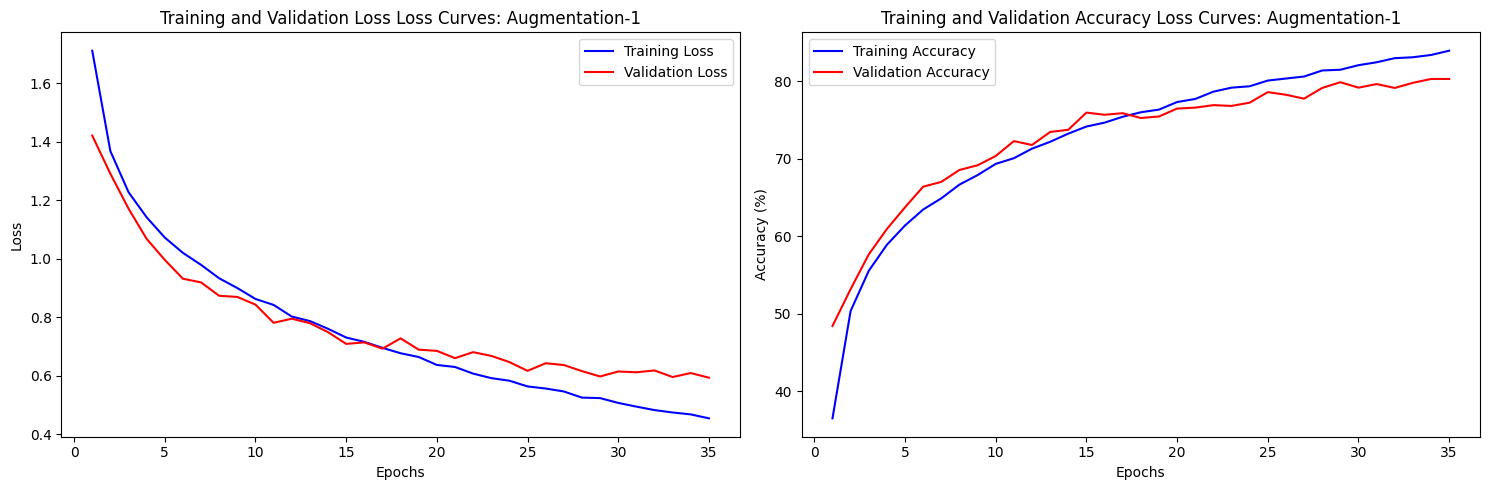

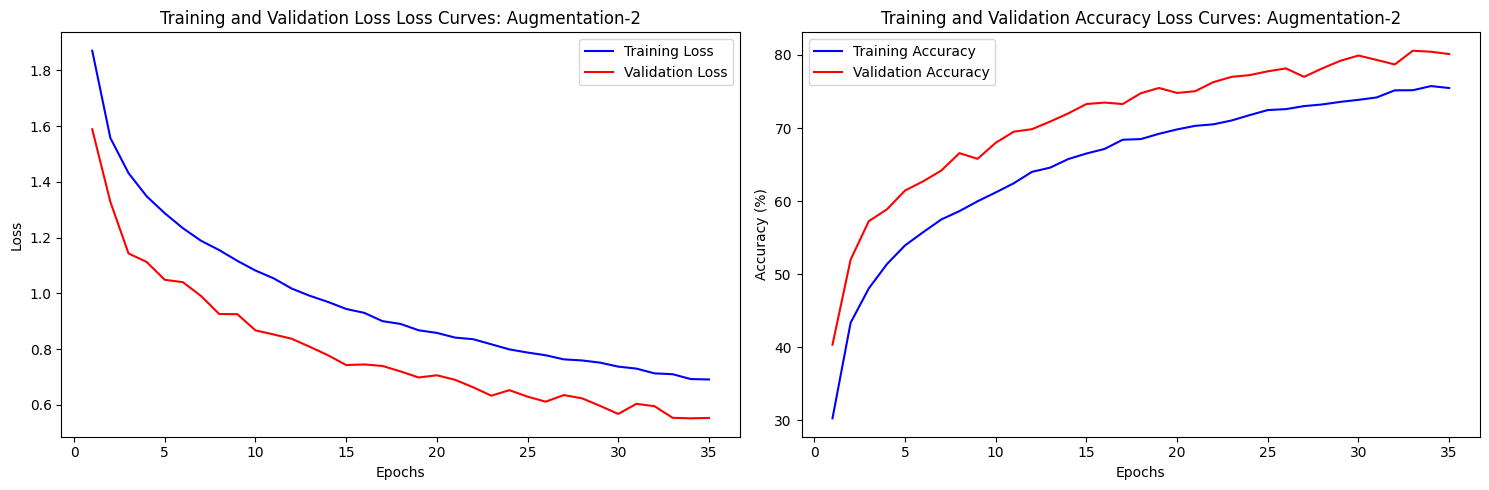

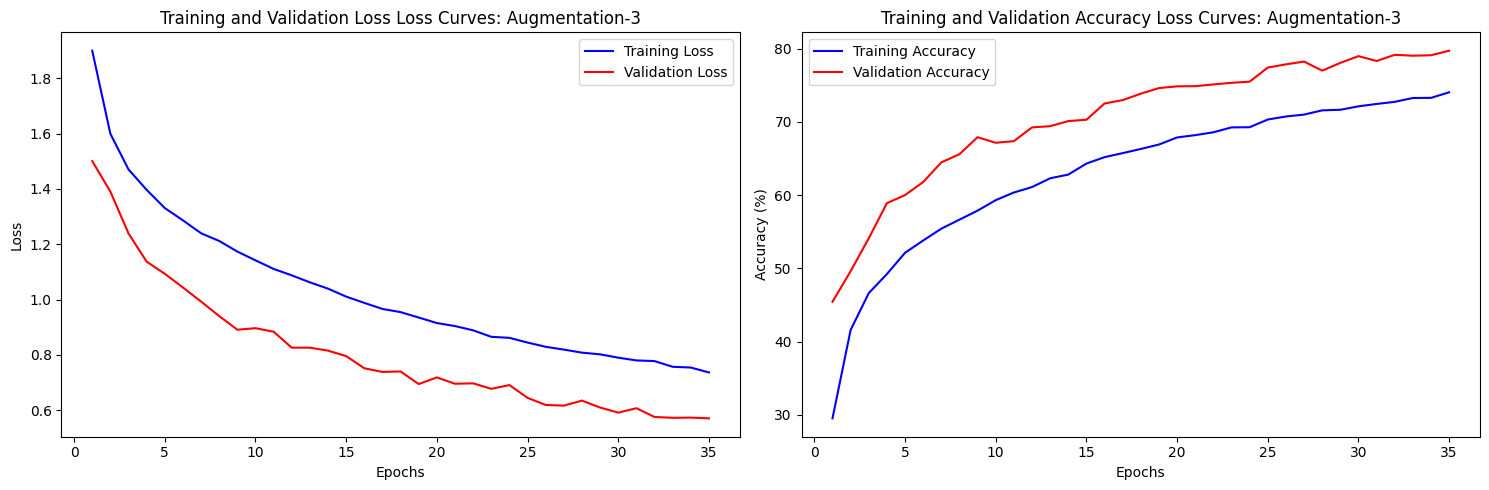

In [29]:
for i, result in enumerate(results):
    plot_loss_curves(result['train_losses'], result['val_losses'], result['train_accs'], result['val_accs'], title=f"Loss Curves: Augmentation-{i + 1}")

In [31]:
print("Test Accuracy with different Augmentations:")
for i, result in enumerate(results):
    print(f"Augmentation-{i + 1} - {result['val_accs'][-1]} ")

Test Accuracy with different Augmentations:
Augmentation-1 - 80.28 
Augmentation-2 - 80.12 
Augmentation-3 - 79.7 


In [33]:
print(results)
print(test_losses)
print(test_accs)

[{'train_losses': [1.7116193795068697, 1.3680390556427566, 1.227698654783043, 1.1415217534046282, 1.0722234655510297, 1.0198612231761217, 0.9788048045540397, 0.9328238508579406, 0.8994432389736176, 0.8620947348800573, 0.8417587452991442, 0.8019228802824562, 0.7865273293785073, 0.7600535945120183, 0.7301709564741362, 0.7153532356023788, 0.6949257166548208, 0.6763741289350119, 0.6634801126677882, 0.6363567327233878, 0.6293919221074744, 0.6067058704793453, 0.5912172414193099, 0.5823861468075351, 0.5628559019585903, 0.555617463266985, 0.5456012524664402, 0.5245554133064367, 0.522829623723572, 0.5064503429457545, 0.49372638651931827, 0.481826814992184, 0.47361858358437364, 0.4671124180101536, 0.4536122405393557], 'val_losses': [1.4212292045354844, 1.2907548606395722, 1.1712971717119216, 1.0677506998181343, 0.9958303093910217, 0.9314289361238479, 0.9187480181455612, 0.8729555293917656, 0.8690277650952339, 0.8427975870668888, 0.7805317744612694, 0.7945825830101967, 0.779350970685482, 0.748569

In [34]:
data = []
for i, (config, result) in enumerate(zip(configurations, results)):
    data.append({
        "Config": f"Augmentation-{i + 1}",
        "Val Loss": result['val_losses'][-2],
        "Val Accuracy (%)": result['val_accs'][-2],
        "Test Loss": test_losses[i],
        "Test Accuracy (%)": test_accs[i]
    })

df = pd.DataFrame(data)

display(df)

,Config,Val Loss,Val Accuracy (%),Test Loss,Test Accuracy (%)
0,Augmentation-1,0.608564,80.28,0.604445,79.98
1,Augmentation-2,0.551355,80.44,0.572812,80.18
2,Augmentation-3,0.573725,79.08,0.562009,80.39


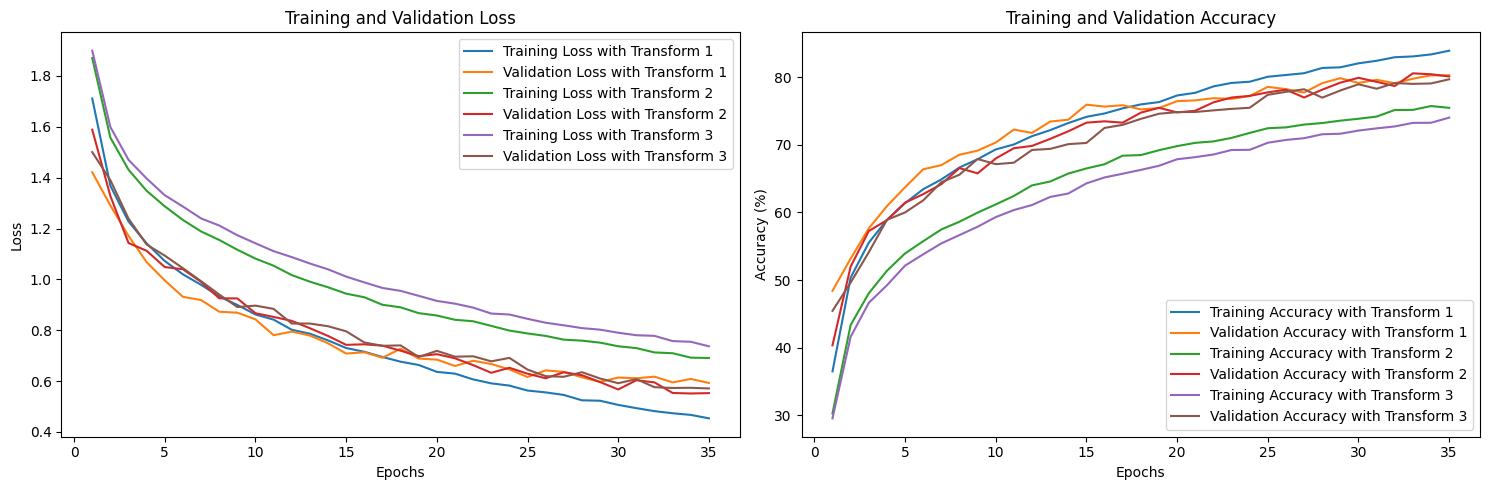

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

epochs = range(1, len(results[0]['train_losses']) + 1)

# Loss plot
for i, result in enumerate(results):
    ax1.plot(epochs, result['train_losses'], label=f'Training Loss with Transform {i+1}')
    ax1.plot(epochs, result['val_losses'], label=f'Validation Loss with Transform {i+1}')

ax1.set_title(f'Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# Accuracy plot
for i, result in enumerate(results):
    ax2.plot(epochs, result['train_accs'], label=f'Training Accuracy with Transform {i+1}')
    ax2.plot(epochs, result['val_accs'], label=f'Validation Accuracy with Transform {i+1}')

ax2.set_title(f'Training and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()

plt.tight_layout()
plt.show()

### Positional embeddings types

In [19]:
pos_embeddings = ['none', '1d_learned', '2d_learned', 'sinusoidal']
results = []

for pos_embds in pos_embeddings:
    model = DiffViT(
        embed_dim=best_config['embed_dim'],
        num_heads=best_config['num_heads'],
        mlp_ratio=best_config['mlp_ratio'],
        num_layers=best_config['num_layers'],
        pos_embed_type=pos_embds
    ).to(device)
    result = train_model(model, trainloader, testloader, num_epochs=NUM_EPOCHS, learning_rate=LEARNING_RATE)
    results.append(result)


Epoch 1/35


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Testing: 100%|██████████| 79/79 [00:02<00:00, 31.61it/s, loss=1.51, acc=45]  


Train Loss: 1.8674 | Train Acc: 30.80%
Val Loss: 1.5140 | Val Acc: 44.98%

Epoch 2/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 32.33it/s, loss=1.44, acc=48]  


Train Loss: 1.6034 | Train Acc: 41.19%
Val Loss: 1.4361 | Val Acc: 47.98%

Epoch 3/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 32.28it/s, loss=1.31, acc=52.8]


Train Loss: 1.4858 | Train Acc: 46.02%
Val Loss: 1.3138 | Val Acc: 52.83%

Epoch 4/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 31.85it/s, loss=1.27, acc=53.1]


Train Loss: 1.4342 | Train Acc: 48.45%
Val Loss: 1.2709 | Val Acc: 53.13%

Epoch 5/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 31.71it/s, loss=1.19, acc=56.3]


Train Loss: 1.3876 | Train Acc: 49.86%
Val Loss: 1.1900 | Val Acc: 56.28%

Epoch 6/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 31.91it/s, loss=1.21, acc=57.2]


Train Loss: 1.3500 | Train Acc: 51.34%
Val Loss: 1.2143 | Val Acc: 57.16%

Epoch 7/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 32.26it/s, loss=1.12, acc=59.5]


Train Loss: 1.3278 | Train Acc: 52.17%
Val Loss: 1.1220 | Val Acc: 59.55%

Epoch 8/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 32.64it/s, loss=1.13, acc=59.5]


Train Loss: 1.2967 | Train Acc: 53.65%
Val Loss: 1.1294 | Val Acc: 59.54%

Epoch 9/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 32.01it/s, loss=1.08, acc=61.3]


Train Loss: 1.2736 | Train Acc: 54.76%
Val Loss: 1.0850 | Val Acc: 61.29%

Epoch 10/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 31.76it/s, loss=1.1, acc=60.9] 


Train Loss: 1.2514 | Train Acc: 54.97%
Val Loss: 1.1026 | Val Acc: 60.85%

Epoch 11/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 31.84it/s, loss=1.06, acc=62.8]


Train Loss: 1.2280 | Train Acc: 56.00%
Val Loss: 1.0573 | Val Acc: 62.80%

Epoch 12/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 31.56it/s, loss=1.03, acc=63.2]


Train Loss: 1.2177 | Train Acc: 56.33%
Val Loss: 1.0335 | Val Acc: 63.18%

Epoch 13/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 32.51it/s, loss=1.04, acc=62.9]


Train Loss: 1.1901 | Train Acc: 57.67%
Val Loss: 1.0374 | Val Acc: 62.87%

Epoch 14/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 32.12it/s, loss=0.991, acc=64.5]


Train Loss: 1.1759 | Train Acc: 58.10%
Val Loss: 0.9905 | Val Acc: 64.45%

Epoch 15/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 31.94it/s, loss=1.01, acc=64]  


Train Loss: 1.1557 | Train Acc: 58.67%
Val Loss: 1.0084 | Val Acc: 63.97%

Epoch 16/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 32.17it/s, loss=0.96, acc=65.7] 


Train Loss: 1.1454 | Train Acc: 59.31%
Val Loss: 0.9596 | Val Acc: 65.74%

Epoch 17/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 32.70it/s, loss=0.963, acc=65.4]


Train Loss: 1.1209 | Train Acc: 59.90%
Val Loss: 0.9634 | Val Acc: 65.37%

Epoch 18/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 32.02it/s, loss=0.92, acc=67.1] 


Train Loss: 1.1116 | Train Acc: 60.43%
Val Loss: 0.9201 | Val Acc: 67.11%

Epoch 19/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 31.76it/s, loss=0.929, acc=67.1]


Train Loss: 1.1036 | Train Acc: 60.63%
Val Loss: 0.9293 | Val Acc: 67.12%

Epoch 20/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 32.14it/s, loss=0.938, acc=67.3]


Train Loss: 1.0855 | Train Acc: 61.36%
Val Loss: 0.9380 | Val Acc: 67.31%

Epoch 21/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 32.26it/s, loss=0.903, acc=68.1]


Train Loss: 1.0629 | Train Acc: 62.46%
Val Loss: 0.9028 | Val Acc: 68.11%

Epoch 22/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 32.40it/s, loss=0.901, acc=67.7]


Train Loss: 1.0595 | Train Acc: 62.16%
Val Loss: 0.9006 | Val Acc: 67.67%

Epoch 23/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 31.81it/s, loss=0.898, acc=67.5]


Train Loss: 1.0451 | Train Acc: 62.74%
Val Loss: 0.8977 | Val Acc: 67.47%

Epoch 24/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 32.38it/s, loss=0.835, acc=70]  


Train Loss: 1.0345 | Train Acc: 63.20%
Val Loss: 0.8351 | Val Acc: 69.98%

Epoch 25/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 31.63it/s, loss=0.825, acc=71]  


Train Loss: 1.0215 | Train Acc: 63.64%
Val Loss: 0.8247 | Val Acc: 71.04%

Epoch 26/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 32.30it/s, loss=0.863, acc=69.9]


Train Loss: 1.0092 | Train Acc: 64.10%
Val Loss: 0.8625 | Val Acc: 69.91%

Epoch 27/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 32.28it/s, loss=0.831, acc=70.7]


Train Loss: 0.9975 | Train Acc: 64.52%
Val Loss: 0.8314 | Val Acc: 70.66%

Epoch 28/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 32.48it/s, loss=0.822, acc=70.8]


Train Loss: 0.9886 | Train Acc: 65.04%
Val Loss: 0.8218 | Val Acc: 70.79%

Epoch 29/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 31.41it/s, loss=0.805, acc=71.3]


Train Loss: 0.9771 | Train Acc: 65.38%
Val Loss: 0.8055 | Val Acc: 71.34%

Epoch 30/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 32.02it/s, loss=0.81, acc=71.2] 


Train Loss: 0.9637 | Train Acc: 65.59%
Val Loss: 0.8097 | Val Acc: 71.20%

Epoch 31/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 32.13it/s, loss=0.817, acc=71]  


Train Loss: 0.9555 | Train Acc: 66.14%
Val Loss: 0.8174 | Val Acc: 71.05%

Epoch 32/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 32.35it/s, loss=0.765, acc=73.2]


Train Loss: 0.9498 | Train Acc: 66.28%
Val Loss: 0.7645 | Val Acc: 73.20%

Epoch 33/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 31.56it/s, loss=0.771, acc=72.3]


Train Loss: 0.9478 | Train Acc: 66.36%
Val Loss: 0.7713 | Val Acc: 72.31%

Epoch 34/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 31.41it/s, loss=0.766, acc=73]  


Train Loss: 0.9292 | Train Acc: 67.09%
Val Loss: 0.7661 | Val Acc: 73.01%

Epoch 35/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 31.80it/s, loss=0.782, acc=72.7]


Train Loss: 0.9248 | Train Acc: 67.10%
Val Loss: 0.7817 | Val Acc: 72.65%

Epoch 1/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 32.05it/s, loss=1.49, acc=45.6]


Train Loss: 1.8683 | Train Acc: 31.00%
Val Loss: 1.4945 | Val Acc: 45.59%

Epoch 2/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 32.39it/s, loss=1.3, acc=52.9] 


Train Loss: 1.5669 | Train Acc: 42.85%
Val Loss: 1.2995 | Val Acc: 52.85%

Epoch 3/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 32.10it/s, loss=1.19, acc=57.1]


Train Loss: 1.4451 | Train Acc: 47.92%
Val Loss: 1.1941 | Val Acc: 57.10%

Epoch 4/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 32.23it/s, loss=1.13, acc=59.6]


Train Loss: 1.3703 | Train Acc: 50.59%
Val Loss: 1.1260 | Val Acc: 59.61%

Epoch 5/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 31.97it/s, loss=1.08, acc=61.9]


Train Loss: 1.3146 | Train Acc: 52.98%
Val Loss: 1.0754 | Val Acc: 61.88%

Epoch 6/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 31.79it/s, loss=1, acc=63.3]    


Train Loss: 1.2606 | Train Acc: 54.53%
Val Loss: 1.0032 | Val Acc: 63.30%

Epoch 7/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 32.47it/s, loss=0.976, acc=65.3]


Train Loss: 1.2171 | Train Acc: 56.36%
Val Loss: 0.9765 | Val Acc: 65.30%

Epoch 8/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 31.95it/s, loss=0.941, acc=66.1]


Train Loss: 1.1728 | Train Acc: 58.17%
Val Loss: 0.9411 | Val Acc: 66.13%

Epoch 9/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 31.79it/s, loss=0.917, acc=66.6]


Train Loss: 1.1435 | Train Acc: 59.06%
Val Loss: 0.9172 | Val Acc: 66.57%

Epoch 10/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 32.49it/s, loss=0.863, acc=68.9]


Train Loss: 1.1023 | Train Acc: 60.83%
Val Loss: 0.8631 | Val Acc: 68.89%

Epoch 11/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 31.55it/s, loss=0.871, acc=69.3]


Train Loss: 1.0789 | Train Acc: 61.67%
Val Loss: 0.8707 | Val Acc: 69.26%

Epoch 12/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 32.32it/s, loss=0.819, acc=71.1]


Train Loss: 1.0539 | Train Acc: 62.60%
Val Loss: 0.8194 | Val Acc: 71.13%

Epoch 13/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 31.87it/s, loss=0.774, acc=72]  


Train Loss: 1.0336 | Train Acc: 63.60%
Val Loss: 0.7741 | Val Acc: 71.95%

Epoch 14/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 32.26it/s, loss=0.796, acc=71.6]


Train Loss: 1.0024 | Train Acc: 64.47%
Val Loss: 0.7962 | Val Acc: 71.59%

Epoch 15/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 31.68it/s, loss=0.768, acc=72.9]


Train Loss: 0.9806 | Train Acc: 65.16%
Val Loss: 0.7680 | Val Acc: 72.87%

Epoch 16/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 31.91it/s, loss=0.781, acc=71.9]


Train Loss: 0.9605 | Train Acc: 65.91%
Val Loss: 0.7811 | Val Acc: 71.89%

Epoch 17/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 32.17it/s, loss=0.747, acc=73.9]


Train Loss: 0.9388 | Train Acc: 67.00%
Val Loss: 0.7469 | Val Acc: 73.88%

Epoch 18/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 31.96it/s, loss=0.698, acc=75.3]


Train Loss: 0.9232 | Train Acc: 67.37%
Val Loss: 0.6984 | Val Acc: 75.30%

Epoch 19/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 32.06it/s, loss=0.663, acc=76.5]


Train Loss: 0.9018 | Train Acc: 68.15%
Val Loss: 0.6634 | Val Acc: 76.48%

Epoch 20/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 32.64it/s, loss=0.655, acc=76.8]


Train Loss: 0.8838 | Train Acc: 68.75%
Val Loss: 0.6547 | Val Acc: 76.79%

Epoch 21/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 32.29it/s, loss=0.686, acc=76.2]


Train Loss: 0.8705 | Train Acc: 69.29%
Val Loss: 0.6863 | Val Acc: 76.22%

Epoch 22/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 32.14it/s, loss=0.627, acc=77.6]


Train Loss: 0.8492 | Train Acc: 69.99%
Val Loss: 0.6269 | Val Acc: 77.64%

Epoch 23/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 32.57it/s, loss=0.636, acc=77.6]


Train Loss: 0.8442 | Train Acc: 70.08%
Val Loss: 0.6365 | Val Acc: 77.57%

Epoch 24/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 32.18it/s, loss=0.621, acc=78]  


Train Loss: 0.8270 | Train Acc: 70.71%
Val Loss: 0.6214 | Val Acc: 77.98%

Epoch 25/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 32.42it/s, loss=0.623, acc=77.8]


Train Loss: 0.8171 | Train Acc: 71.02%
Val Loss: 0.6228 | Val Acc: 77.75%

Epoch 26/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 32.73it/s, loss=0.593, acc=78.9]


Train Loss: 0.7975 | Train Acc: 71.75%
Val Loss: 0.5926 | Val Acc: 78.86%

Epoch 27/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 31.79it/s, loss=0.606, acc=78.2]


Train Loss: 0.7848 | Train Acc: 72.18%
Val Loss: 0.6064 | Val Acc: 78.25%

Epoch 28/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 31.97it/s, loss=0.576, acc=80]  


Train Loss: 0.7773 | Train Acc: 72.61%
Val Loss: 0.5758 | Val Acc: 80.00%

Epoch 29/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 32.51it/s, loss=0.603, acc=78.5]


Train Loss: 0.7599 | Train Acc: 73.26%
Val Loss: 0.6027 | Val Acc: 78.54%

Epoch 30/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 32.09it/s, loss=0.581, acc=79]  


Train Loss: 0.7642 | Train Acc: 73.12%
Val Loss: 0.5811 | Val Acc: 79.05%

Epoch 31/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 32.20it/s, loss=0.571, acc=80]  


Train Loss: 0.7479 | Train Acc: 73.65%
Val Loss: 0.5708 | Val Acc: 80.05%

Epoch 32/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 32.27it/s, loss=0.551, acc=80.8]


Train Loss: 0.7432 | Train Acc: 73.75%
Val Loss: 0.5505 | Val Acc: 80.78%

Epoch 33/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 32.03it/s, loss=0.527, acc=81.5]


Train Loss: 0.7272 | Train Acc: 74.44%
Val Loss: 0.5268 | Val Acc: 81.52%

Epoch 34/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 32.17it/s, loss=0.556, acc=80.4]


Train Loss: 0.7150 | Train Acc: 74.73%
Val Loss: 0.5565 | Val Acc: 80.43%

Epoch 35/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 31.46it/s, loss=0.551, acc=80.6]


Train Loss: 0.7113 | Train Acc: 74.83%
Val Loss: 0.5514 | Val Acc: 80.58%

Epoch 1/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 31.87it/s, loss=1.46, acc=47.2]


Train Loss: 1.8532 | Train Acc: 31.11%
Val Loss: 1.4620 | Val Acc: 47.25%

Epoch 2/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 31.57it/s, loss=1.3, acc=52.6] 


Train Loss: 1.5637 | Train Acc: 43.11%
Val Loss: 1.2955 | Val Acc: 52.64%

Epoch 3/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 31.88it/s, loss=1.21, acc=56.6]


Train Loss: 1.4391 | Train Acc: 47.72%
Val Loss: 1.2079 | Val Acc: 56.56%

Epoch 4/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 31.37it/s, loss=1.17, acc=57.8]


Train Loss: 1.3583 | Train Acc: 51.07%
Val Loss: 1.1712 | Val Acc: 57.79%

Epoch 5/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 31.51it/s, loss=1.08, acc=61]  


Train Loss: 1.3042 | Train Acc: 53.33%
Val Loss: 1.0784 | Val Acc: 61.04%

Epoch 6/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 31.93it/s, loss=0.993, acc=63.9]


Train Loss: 1.2504 | Train Acc: 54.96%
Val Loss: 0.9935 | Val Acc: 63.91%

Epoch 7/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 31.94it/s, loss=0.943, acc=66]  


Train Loss: 1.2148 | Train Acc: 56.61%
Val Loss: 0.9427 | Val Acc: 66.05%

Epoch 8/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 31.51it/s, loss=0.919, acc=67]  


Train Loss: 1.1656 | Train Acc: 58.37%
Val Loss: 0.9189 | Val Acc: 66.96%

Epoch 9/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 31.39it/s, loss=0.894, acc=67.9]


Train Loss: 1.1377 | Train Acc: 59.35%
Val Loss: 0.8935 | Val Acc: 67.90%

Epoch 10/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 31.59it/s, loss=0.886, acc=67.8]


Train Loss: 1.1049 | Train Acc: 60.50%
Val Loss: 0.8861 | Val Acc: 67.84%

Epoch 11/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 28.63it/s, loss=0.825, acc=70.4]


Train Loss: 1.0727 | Train Acc: 61.71%
Val Loss: 0.8253 | Val Acc: 70.40%

Epoch 12/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 31.46it/s, loss=0.825, acc=70.3]


Train Loss: 1.0471 | Train Acc: 62.71%
Val Loss: 0.8255 | Val Acc: 70.33%

Epoch 13/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 31.44it/s, loss=0.819, acc=70.5]


Train Loss: 1.0210 | Train Acc: 63.54%
Val Loss: 0.8188 | Val Acc: 70.49%

Epoch 14/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 31.67it/s, loss=0.783, acc=71.8]


Train Loss: 1.0057 | Train Acc: 64.41%
Val Loss: 0.7833 | Val Acc: 71.79%

Epoch 15/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 32.33it/s, loss=0.766, acc=72.7]


Train Loss: 0.9804 | Train Acc: 65.50%
Val Loss: 0.7659 | Val Acc: 72.71%

Epoch 16/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 32.03it/s, loss=0.733, acc=74.2]


Train Loss: 0.9556 | Train Acc: 66.21%
Val Loss: 0.7332 | Val Acc: 74.25%

Epoch 17/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 31.83it/s, loss=0.71, acc=75.2] 


Train Loss: 0.9388 | Train Acc: 66.82%
Val Loss: 0.7096 | Val Acc: 75.16%

Epoch 18/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 32.55it/s, loss=0.691, acc=75.5]


Train Loss: 0.9234 | Train Acc: 67.13%
Val Loss: 0.6914 | Val Acc: 75.52%

Epoch 19/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 31.36it/s, loss=0.685, acc=76]  


Train Loss: 0.9018 | Train Acc: 68.27%
Val Loss: 0.6847 | Val Acc: 75.96%

Epoch 20/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 32.29it/s, loss=0.676, acc=76.4]


Train Loss: 0.8878 | Train Acc: 68.51%
Val Loss: 0.6763 | Val Acc: 76.36%

Epoch 21/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 31.82it/s, loss=0.692, acc=75.8]


Train Loss: 0.8665 | Train Acc: 69.35%
Val Loss: 0.6916 | Val Acc: 75.83%

Epoch 22/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 31.65it/s, loss=0.646, acc=77.6]


Train Loss: 0.8567 | Train Acc: 69.63%
Val Loss: 0.6461 | Val Acc: 77.64%

Epoch 23/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 32.27it/s, loss=0.65, acc=77]   


Train Loss: 0.8419 | Train Acc: 70.11%
Val Loss: 0.6504 | Val Acc: 76.95%

Epoch 24/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 31.70it/s, loss=0.612, acc=78.3]


Train Loss: 0.8300 | Train Acc: 70.72%
Val Loss: 0.6116 | Val Acc: 78.29%

Epoch 25/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 32.39it/s, loss=0.608, acc=78.6]


Train Loss: 0.8177 | Train Acc: 71.05%
Val Loss: 0.6078 | Val Acc: 78.64%

Epoch 26/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 31.74it/s, loss=0.618, acc=78.2]


Train Loss: 0.8077 | Train Acc: 71.31%
Val Loss: 0.6176 | Val Acc: 78.24%

Epoch 27/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 31.22it/s, loss=0.611, acc=78.3]


Train Loss: 0.7979 | Train Acc: 71.76%
Val Loss: 0.6112 | Val Acc: 78.33%

Epoch 28/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 32.20it/s, loss=0.607, acc=78.4]


Train Loss: 0.7791 | Train Acc: 72.54%
Val Loss: 0.6067 | Val Acc: 78.37%

Epoch 29/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 32.57it/s, loss=0.584, acc=79.7]


Train Loss: 0.7797 | Train Acc: 72.42%
Val Loss: 0.5844 | Val Acc: 79.68%

Epoch 30/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 31.46it/s, loss=0.567, acc=80.1]


Train Loss: 0.7644 | Train Acc: 73.04%
Val Loss: 0.5674 | Val Acc: 80.06%

Epoch 31/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 31.95it/s, loss=0.582, acc=79.6]


Train Loss: 0.7506 | Train Acc: 73.71%
Val Loss: 0.5822 | Val Acc: 79.57%

Epoch 32/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 32.54it/s, loss=0.549, acc=80.6]


Train Loss: 0.7442 | Train Acc: 73.72%
Val Loss: 0.5486 | Val Acc: 80.59%

Epoch 33/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 31.64it/s, loss=0.556, acc=81.1]


Train Loss: 0.7340 | Train Acc: 74.01%
Val Loss: 0.5556 | Val Acc: 81.14%

Epoch 34/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 31.43it/s, loss=0.564, acc=80.5]


Train Loss: 0.7241 | Train Acc: 74.31%
Val Loss: 0.5642 | Val Acc: 80.46%

Epoch 35/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 32.15it/s, loss=0.535, acc=81.5]


Train Loss: 0.7214 | Train Acc: 74.62%
Val Loss: 0.5352 | Val Acc: 81.50%

Epoch 1/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 32.07it/s, loss=1.38, acc=51.2]


Train Loss: 1.8413 | Train Acc: 32.27%
Val Loss: 1.3753 | Val Acc: 51.16%

Epoch 2/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 31.59it/s, loss=1.27, acc=54.4]


Train Loss: 1.5346 | Train Acc: 44.38%
Val Loss: 1.2714 | Val Acc: 54.43%

Epoch 3/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 31.74it/s, loss=1.18, acc=57.4]


Train Loss: 1.4212 | Train Acc: 48.87%
Val Loss: 1.1764 | Val Acc: 57.39%

Epoch 4/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 32.39it/s, loss=1.06, acc=61.9]


Train Loss: 1.3423 | Train Acc: 51.72%
Val Loss: 1.0603 | Val Acc: 61.92%

Epoch 5/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 32.86it/s, loss=1.04, acc=63]  


Train Loss: 1.2794 | Train Acc: 54.06%
Val Loss: 1.0423 | Val Acc: 63.00%

Epoch 6/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 32.13it/s, loss=0.957, acc=66]  


Train Loss: 1.2275 | Train Acc: 55.90%
Val Loss: 0.9570 | Val Acc: 66.02%

Epoch 7/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 32.08it/s, loss=0.927, acc=66.7]


Train Loss: 1.1867 | Train Acc: 57.39%
Val Loss: 0.9266 | Val Acc: 66.70%

Epoch 8/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 32.21it/s, loss=0.919, acc=67.5]


Train Loss: 1.1517 | Train Acc: 58.83%
Val Loss: 0.9190 | Val Acc: 67.50%

Epoch 9/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 32.01it/s, loss=0.902, acc=67.7]


Train Loss: 1.1128 | Train Acc: 60.30%
Val Loss: 0.9023 | Val Acc: 67.67%

Epoch 10/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 32.48it/s, loss=0.84, acc=70]   


Train Loss: 1.0890 | Train Acc: 61.32%
Val Loss: 0.8399 | Val Acc: 69.97%

Epoch 11/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 31.83it/s, loss=0.827, acc=71]  


Train Loss: 1.0509 | Train Acc: 62.74%
Val Loss: 0.8268 | Val Acc: 70.97%

Epoch 12/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 32.31it/s, loss=0.807, acc=71.5]


Train Loss: 1.0297 | Train Acc: 63.28%
Val Loss: 0.8069 | Val Acc: 71.52%

Epoch 13/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 32.46it/s, loss=0.771, acc=72.4]


Train Loss: 1.0038 | Train Acc: 64.48%
Val Loss: 0.7709 | Val Acc: 72.40%

Epoch 14/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 31.94it/s, loss=0.773, acc=72.8]


Train Loss: 0.9837 | Train Acc: 65.16%
Val Loss: 0.7733 | Val Acc: 72.83%

Epoch 15/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 32.27it/s, loss=0.729, acc=74]  


Train Loss: 0.9644 | Train Acc: 65.95%
Val Loss: 0.7292 | Val Acc: 74.05%

Epoch 16/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 31.85it/s, loss=0.746, acc=74]  


Train Loss: 0.9397 | Train Acc: 66.72%
Val Loss: 0.7462 | Val Acc: 74.01%

Epoch 17/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 32.45it/s, loss=0.69, acc=75.5] 


Train Loss: 0.9231 | Train Acc: 67.36%
Val Loss: 0.6899 | Val Acc: 75.55%

Epoch 18/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 32.13it/s, loss=0.707, acc=74.9]


Train Loss: 0.8969 | Train Acc: 68.49%
Val Loss: 0.7066 | Val Acc: 74.93%

Epoch 19/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 32.57it/s, loss=0.661, acc=76.6]


Train Loss: 0.8838 | Train Acc: 69.00%
Val Loss: 0.6610 | Val Acc: 76.62%

Epoch 20/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 32.03it/s, loss=0.675, acc=76.4]


Train Loss: 0.8628 | Train Acc: 69.77%
Val Loss: 0.6746 | Val Acc: 76.43%

Epoch 21/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 31.91it/s, loss=0.656, acc=77.3]


Train Loss: 0.8594 | Train Acc: 69.57%
Val Loss: 0.6555 | Val Acc: 77.30%

Epoch 22/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 32.30it/s, loss=0.645, acc=77.7]


Train Loss: 0.8386 | Train Acc: 70.53%
Val Loss: 0.6450 | Val Acc: 77.72%

Epoch 23/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 32.25it/s, loss=0.659, acc=77.4]


Train Loss: 0.8269 | Train Acc: 70.82%
Val Loss: 0.6593 | Val Acc: 77.44%

Epoch 24/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 31.81it/s, loss=0.643, acc=77.6]


Train Loss: 0.8171 | Train Acc: 71.26%
Val Loss: 0.6426 | Val Acc: 77.61%

Epoch 25/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 32.19it/s, loss=0.668, acc=76.1]


Train Loss: 0.8111 | Train Acc: 71.57%
Val Loss: 0.6683 | Val Acc: 76.14%

Epoch 26/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 32.24it/s, loss=0.614, acc=78.5]


Train Loss: 0.7948 | Train Acc: 72.09%
Val Loss: 0.6138 | Val Acc: 78.54%

Epoch 27/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 31.74it/s, loss=0.609, acc=79.1]


Train Loss: 0.7796 | Train Acc: 72.75%
Val Loss: 0.6090 | Val Acc: 79.08%

Epoch 28/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 31.69it/s, loss=0.627, acc=77.6]


Train Loss: 0.7726 | Train Acc: 72.94%
Val Loss: 0.6274 | Val Acc: 77.57%

Epoch 29/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 32.42it/s, loss=0.57, acc=79.8] 


Train Loss: 0.7671 | Train Acc: 73.23%
Val Loss: 0.5703 | Val Acc: 79.75%

Epoch 30/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 29.11it/s, loss=0.576, acc=79.4]


Train Loss: 0.7489 | Train Acc: 73.63%
Val Loss: 0.5764 | Val Acc: 79.44%

Epoch 31/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 32.15it/s, loss=0.591, acc=79.3]


Train Loss: 0.7428 | Train Acc: 73.97%
Val Loss: 0.5910 | Val Acc: 79.34%

Epoch 32/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 32.41it/s, loss=0.574, acc=80.1]


Train Loss: 0.7396 | Train Acc: 73.95%
Val Loss: 0.5744 | Val Acc: 80.14%

Epoch 33/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 32.27it/s, loss=0.617, acc=78.5]


Train Loss: 0.7226 | Train Acc: 74.45%
Val Loss: 0.6173 | Val Acc: 78.54%

Epoch 34/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 32.35it/s, loss=0.554, acc=80.7]


Train Loss: 0.7166 | Train Acc: 74.86%
Val Loss: 0.5536 | Val Acc: 80.72%

Epoch 35/35


Testing: 100%|██████████| 79/79 [00:02<00:00, 31.44it/s, loss=0.533, acc=81.7]

Train Loss: 0.7119 | Train Acc: 75.00%
Val Loss: 0.5328 | Val Acc: 81.71%


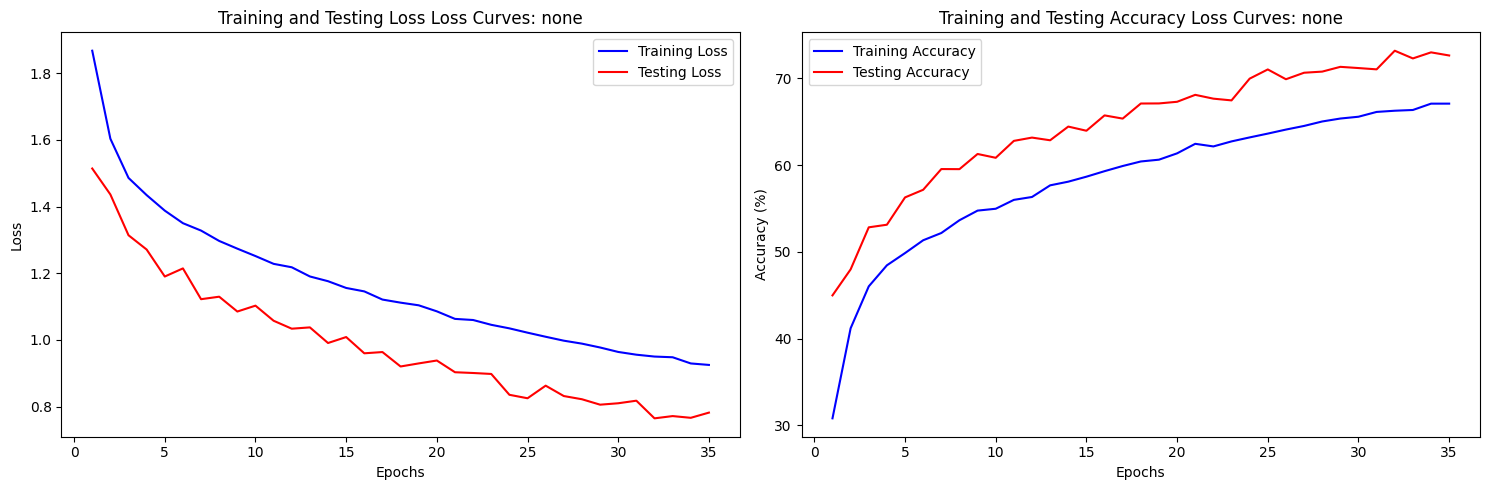

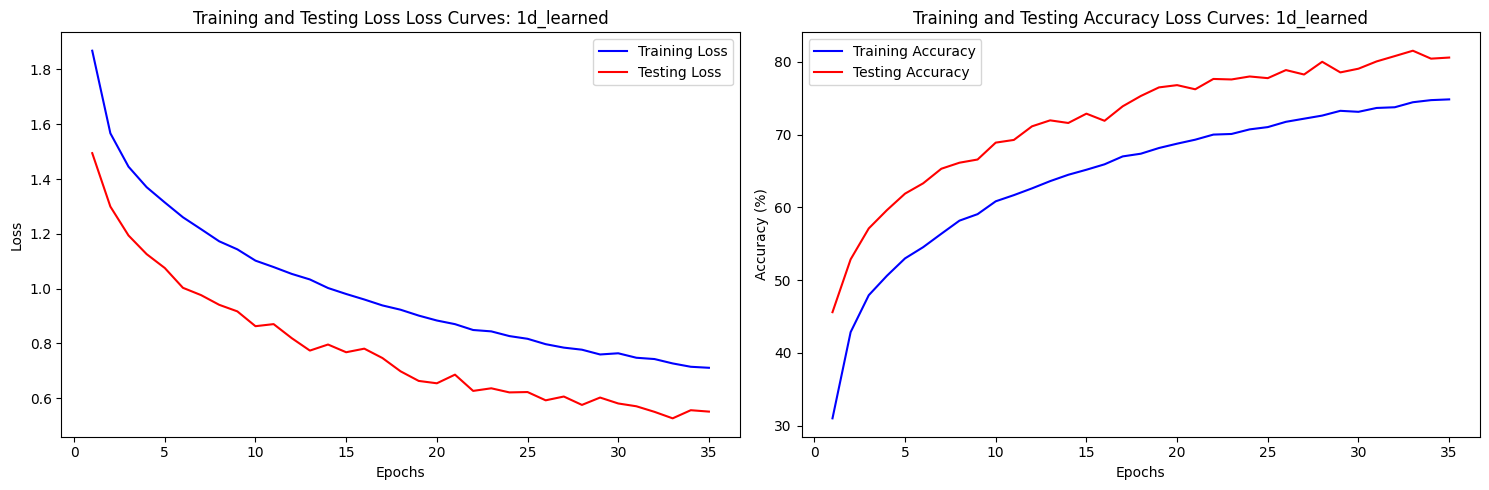

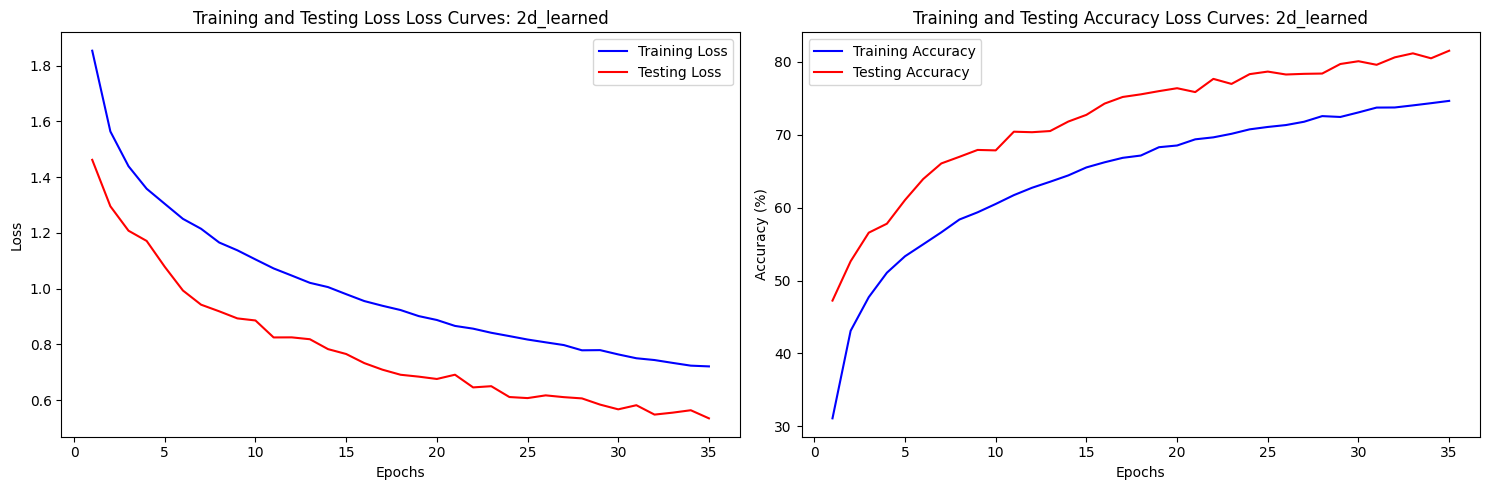

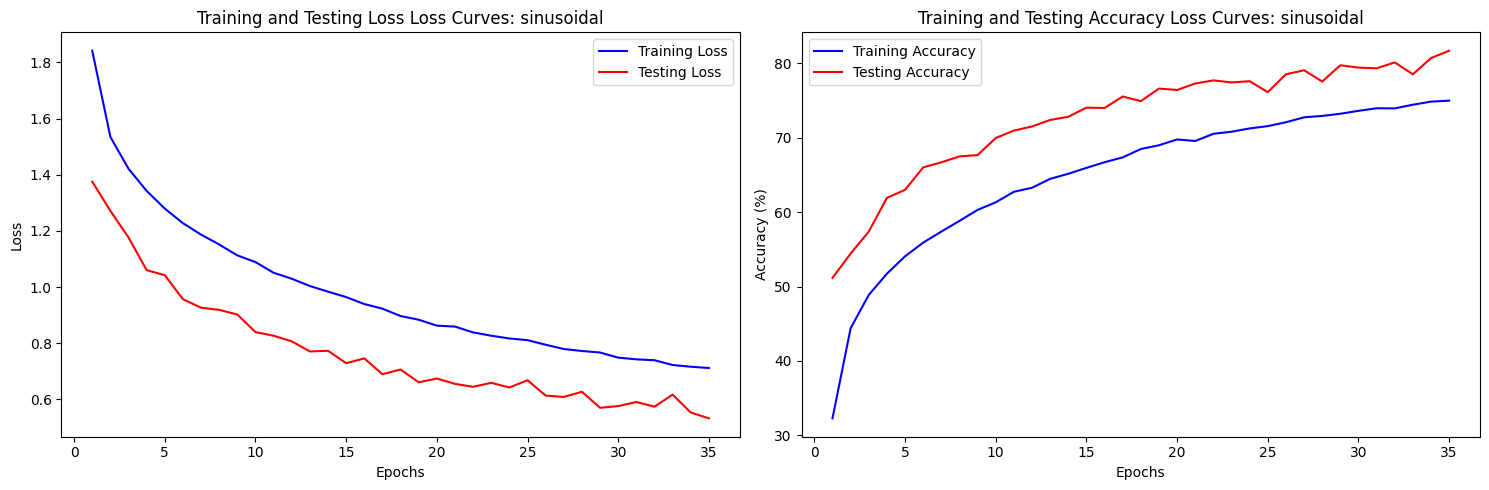

In [20]:
for result, pos_embd in zip(results, pos_embeddings):
    plot_loss_curves(result['train_losses'], result['test_losses'], result['train_accs'], result['test_accs'], title=f"Loss Curves: {pos_embd}")

In [21]:
print("Test Accuracy with different positional embeddings:")
for pos_embd, result in zip(pos_embeddings, results):
    print(f"Positional Embedding Type: {pos_embd} - {result['test_accs'][-1]} ")

Test Accuracy with different positional embeddings:
Positional Embedding Type: none - 72.65 
Positional Embedding Type: 1d_learned - 80.58 
Positional Embedding Type: 2d_learned - 81.5 
Positional Embedding Type: sinusoidal - 81.71 


## 2.3 Visualization

In [22]:

def attention_rollout(attention_maps, discard_ratio=0.9):
    num_layers = len(attention_maps)
    B, H, N, _ = attention_maps[0].shape
    attention_rollout = torch.eye(N).unsqueeze(0).repeat(B, 1, 1).to(attention_maps[0].device)

    for attention_map in attention_maps:
        layer_attention = attention_map.mean(dim=1)  # [B, N, N]
        if discard_ratio > 0:

            flat_attn = layer_attention.view(B, -1)
            threshold_values = torch.kthvalue(
                flat_attn, 
                k=int(flat_attn.shape[1] * discard_ratio), 
                dim=1, 
                keepdim=True
            )[0]
            threshold_values = threshold_values.view(B, 1, 1)
            mask = (layer_attention >= threshold_values).float()

            layer_attention = layer_attention * mask
            row_sums = layer_attention.sum(dim=-1, keepdim=True)
            row_sums[row_sums == 0] = 1.0  
            layer_attention = layer_attention / row_sums
        
        attention_rollout = torch.bmm(layer_attention, attention_rollout)
    
    return attention_rollout

def visualize_attention(image_tensor, attention_map, patch_size):
    img = image_tensor.permute(1, 2, 0).cpu().numpy()
    img = (img - img.min()) / (img.max() - img.min())
    cls_attention = attention_map[0, 1:].cpu().numpy()
    # cls_attention = (cls_attention - cls_attention.min()) / (cls_attention.max() - cls_attention.min() + 1e-8)

    img_h, img_w = image_tensor.shape[1], image_tensor.shape[2]
    num_patches_h, num_patches_w = img_h // patch_size, img_w // patch_size

    attention_map_img = cls_attention.reshape(num_patches_h, num_patches_w)
    attention_map_img = cv2.resize(attention_map_img, (img_w, img_h))

    attention_map_heatmap = np.uint8(255 * np.clip(attention_map_img, 0, 1))
    attention_map_heatmap = cv2.applyColorMap(attention_map_heatmap, cv2.COLORMAP_JET)
    attention_map_heatmap = cv2.cvtColor(attention_map_heatmap, cv2.COLOR_BGR2RGB) / 255.0
    
    alpha = 0.6  # Transparency factor
    plt.figure(figsize=(10, 10))

    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(attention_map_img, cmap='viridis')
    plt.title("Attention Map")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(img * (1-alpha) + attention_map_heatmap * alpha)
    plt.title("Overlay")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

def visualize_multi_head_attention(image_tensor, attention_maps, patch_size, layer_idx):

    _, num_heads, _, _ = attention_maps.shape
    num_plots = num_heads + 2  # 1 original + num_heads + 1 avg
    grid_size = int(np.ceil(np.sqrt(num_plots)))

    plt.figure(figsize=(15, 15))
 
    img = image_tensor.permute(1, 2, 0).cpu().numpy()
    img = (img - img.min()) / (img.max() - img.min())
    
    plt.subplot(grid_size, grid_size, 1)
    plt.imshow(img)
    plt.title("Original Image")
    plt.axis('off')

    for h in range(num_heads):
        cls_attention = attention_maps[0, h, 0, 1:].cpu().numpy()
        img_h, img_w = image_tensor.shape[1], image_tensor.shape[2]
        num_patches_h, num_patches_w = img_h // patch_size, img_w // patch_size

        attention_map_img = cls_attention.reshape(num_patches_h, num_patches_w)
        attention_map_img = cv2.resize(attention_map_img, (img_w, img_h))

        plt.subplot(grid_size, grid_size, h + 2)  # +2 because we started with original image
        plt.imshow(attention_map_img, cmap='viridis')
        plt.title(f"Head {h}")
        plt.axis('off')

    avg_attention = attention_maps[0, :, 0, 1:].mean(dim=0).cpu().numpy()
    avg_attention_img = avg_attention.reshape(num_patches_h, num_patches_w)
    avg_attention_img = cv2.resize(avg_attention_img, (img_w, img_h))

    plt.subplot(grid_size, grid_size, num_heads + 2)
    plt.imshow(avg_attention_img, cmap='viridis')
    plt.title("Average Attention")
    plt.axis('off')
    
    plt.suptitle(f"Layer {layer_idx} Attention Maps", fontsize=16)
    plt.tight_layout()
    plt.show()


def visualize_rollout(image_tensor, rollout_map, patch_size):
    img = image_tensor.permute(1, 2, 0).cpu().numpy()
    img = (img - img.min()) / (img.max() - img.min())

    cls_rollout = rollout_map[0, 1:].cpu().numpy()

    img_h, img_w = image_tensor.shape[1], image_tensor.shape[2]
    num_patches_h, num_patches_w = img_h // patch_size, img_w // patch_size

    rollout_img = cls_rollout.reshape(num_patches_h, num_patches_w)
    rollout_img = cv2.resize(rollout_img, (img_w, img_h))

    rollout_img_heatmap = np.uint8(255 * rollout_img)
    rollout_img_heatmap = cv2.applyColorMap(rollout_img_heatmap, cv2.COLORMAP_JET)
    rollout_img_heatmap = cv2.cvtColor(rollout_img_heatmap, cv2.COLOR_BGR2RGB) / 255.0
    
    alpha = 0.5  # Transparency factor
    plt.figure(figsize=(10, 10))

    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(rollout_img, cmap='viridis')
    plt.title("Attention Rollout")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(img * (1-alpha) + rollout_img_heatmap * alpha)
    plt.title("Overlay")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()


def run_visualizations(model_path, config, testset, patch_size=4, num_images=1):
    model = DiffViT(
        embed_dim=config['embed_dim'],
        num_heads=config['num_heads'],
        mlp_ratio=config['mlp_ratio'],
        num_layers=config['num_layers'],
    ).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()

    testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=True)
    classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    for i, (image, label) in enumerate(testloader):
        if i >= num_images:
            break
        
        image = image.to(device)
        with torch.no_grad():
            logits, attention_maps = model(image, return_attention=True)

            vis_image = image.clone().detach()
            mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1).to(device)
            std = torch.tensor([0.2470, 0.2435, 0.2616]).view(3, 1, 1).to(device)
            vis_image = vis_image * std + mean  # Denormalize
            vis_image.clamp_(0, 1)

            pred = logits.argmax(dim=1).item()
            class_name = classes[label.item()]
            pred_name = classes[pred]
            
            print(f"\nImage {i+1}: True: {class_name}, Predicted: {pred_name}")

            last_attn = attention_maps[-1]  # Last layer attention
            avg_last_attn = last_attn.mean(dim=1)  # [B, N, N]

            print("Attention Maps:")
            visualize_attention(vis_image[0], avg_last_attn[0], patch_size)
            visualize_multi_head_attention(vis_image[0], last_attn, patch_size, "Last")
            for layer_idx, attn in enumerate(attention_maps):
                visualize_multi_head_attention(vis_image[0], attn, patch_size, layer_idx)
            
            print("Attention Map using attention rollout:")
            rollout = attention_rollout(attention_maps)
            visualize_rollout(vis_image[0], rollout[0], patch_size)

                


Image 1: True: car, Predicted: car
Attention Maps:


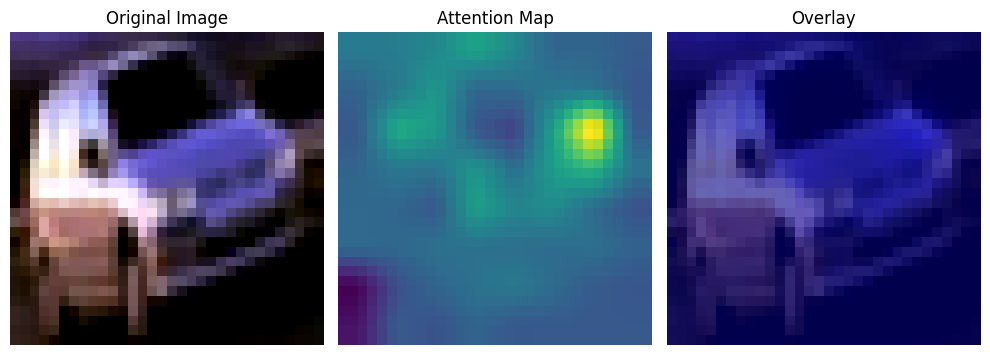

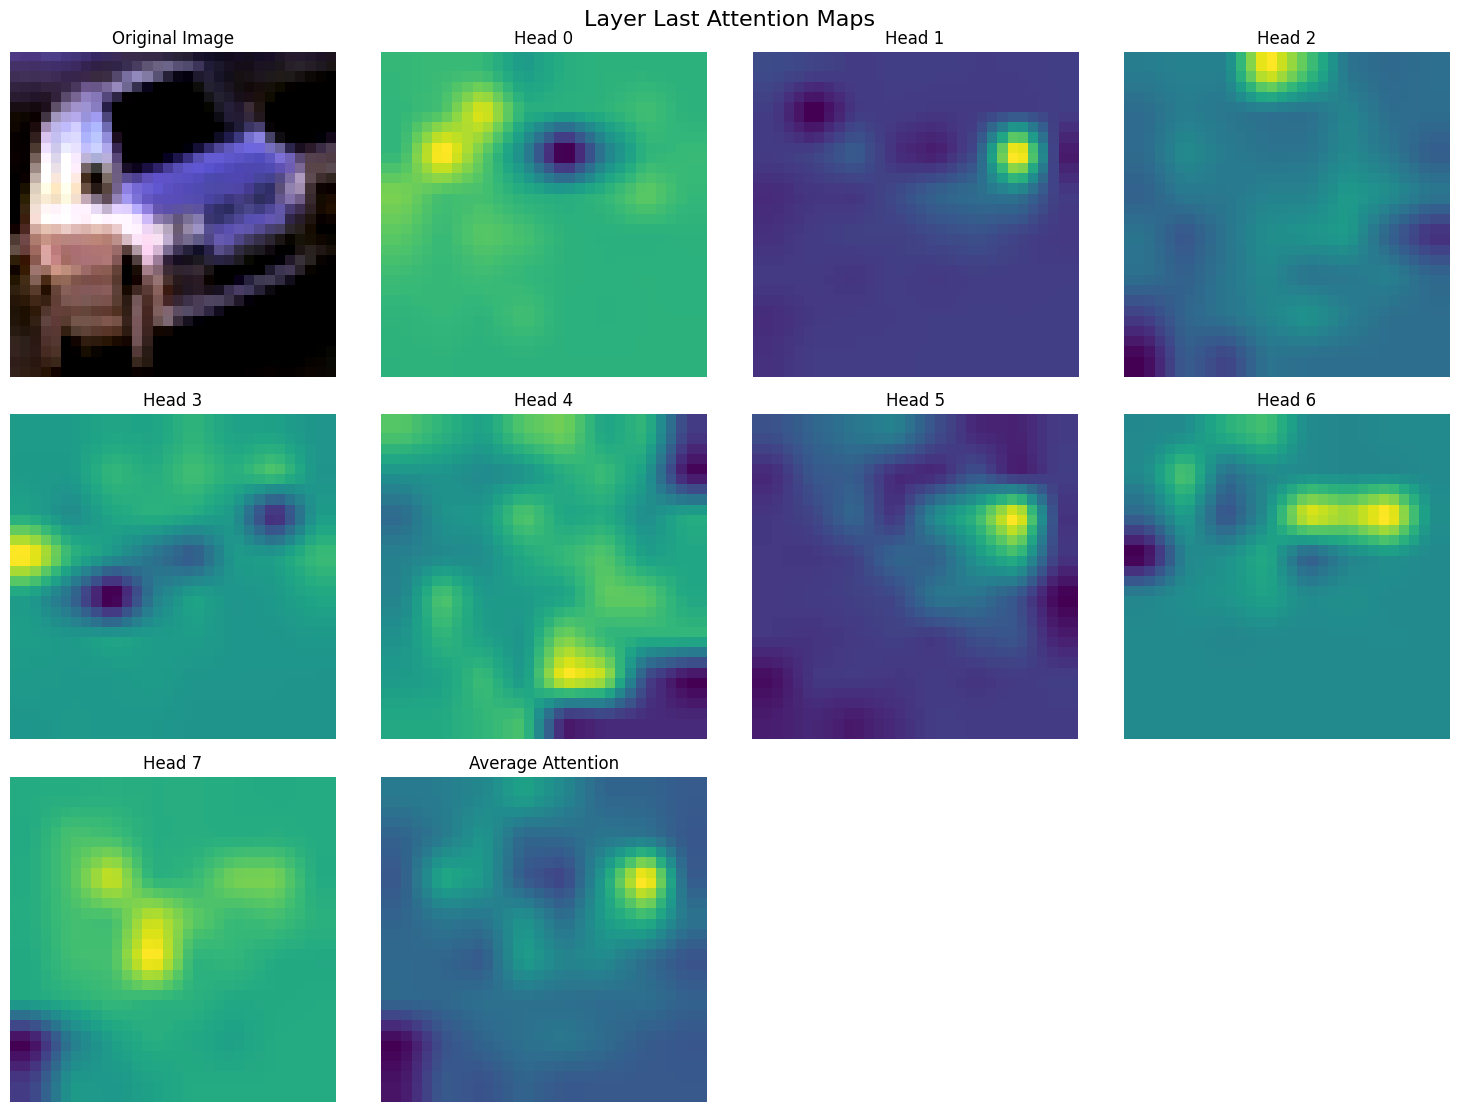

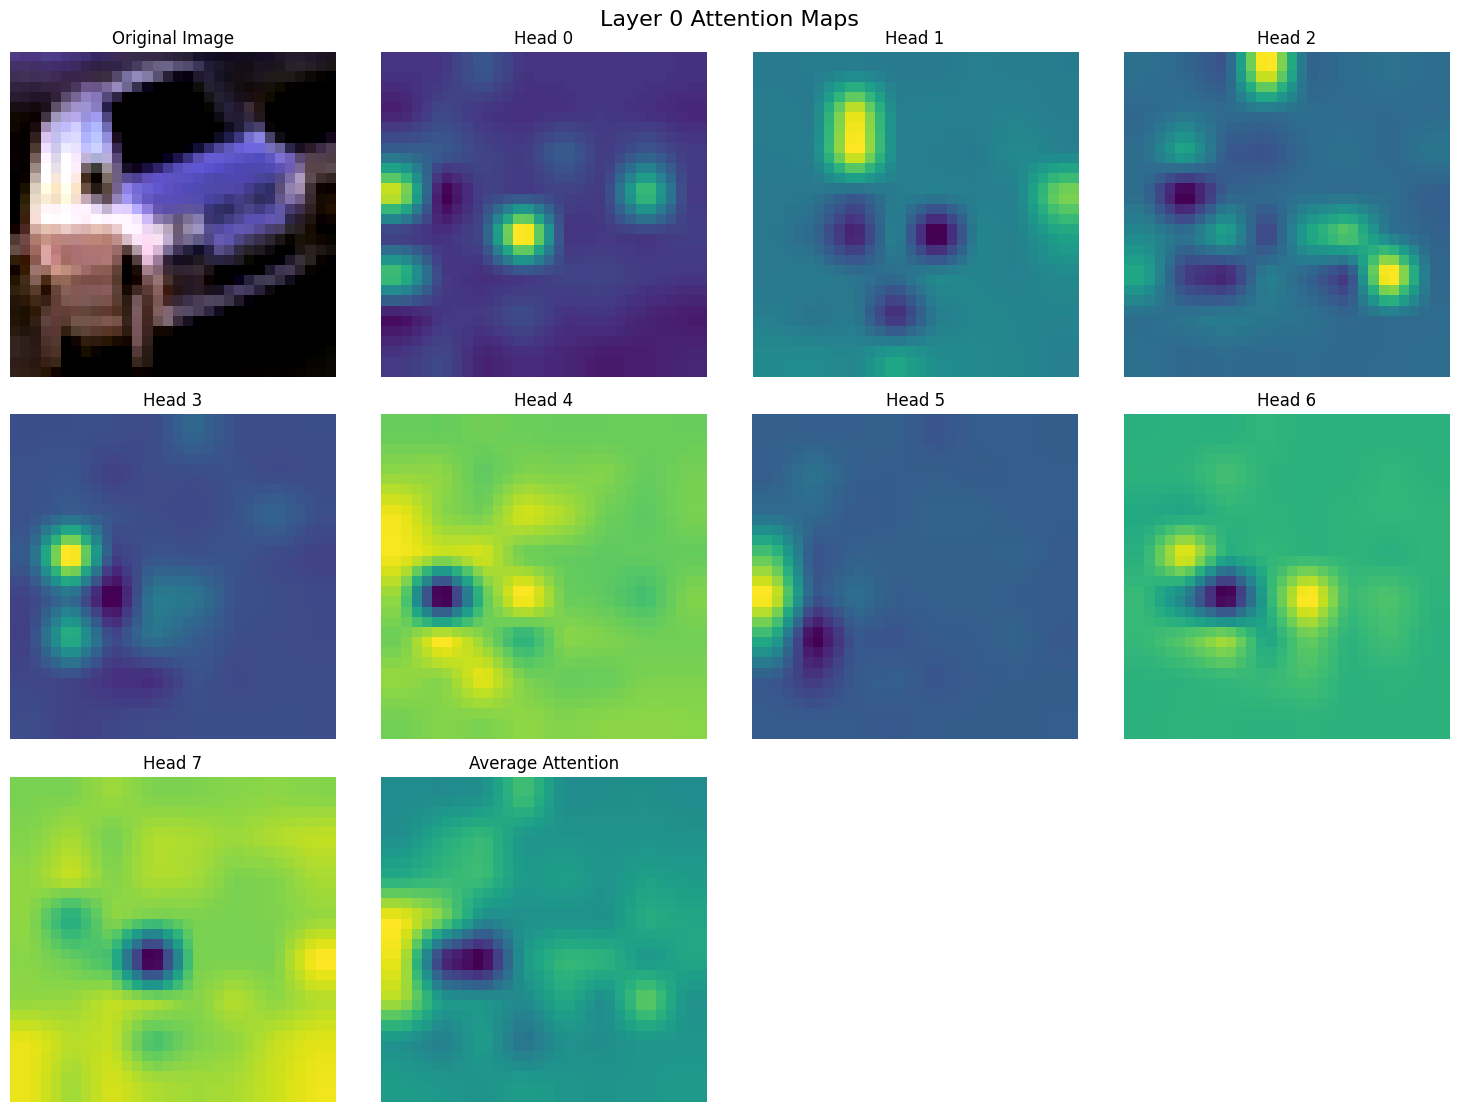

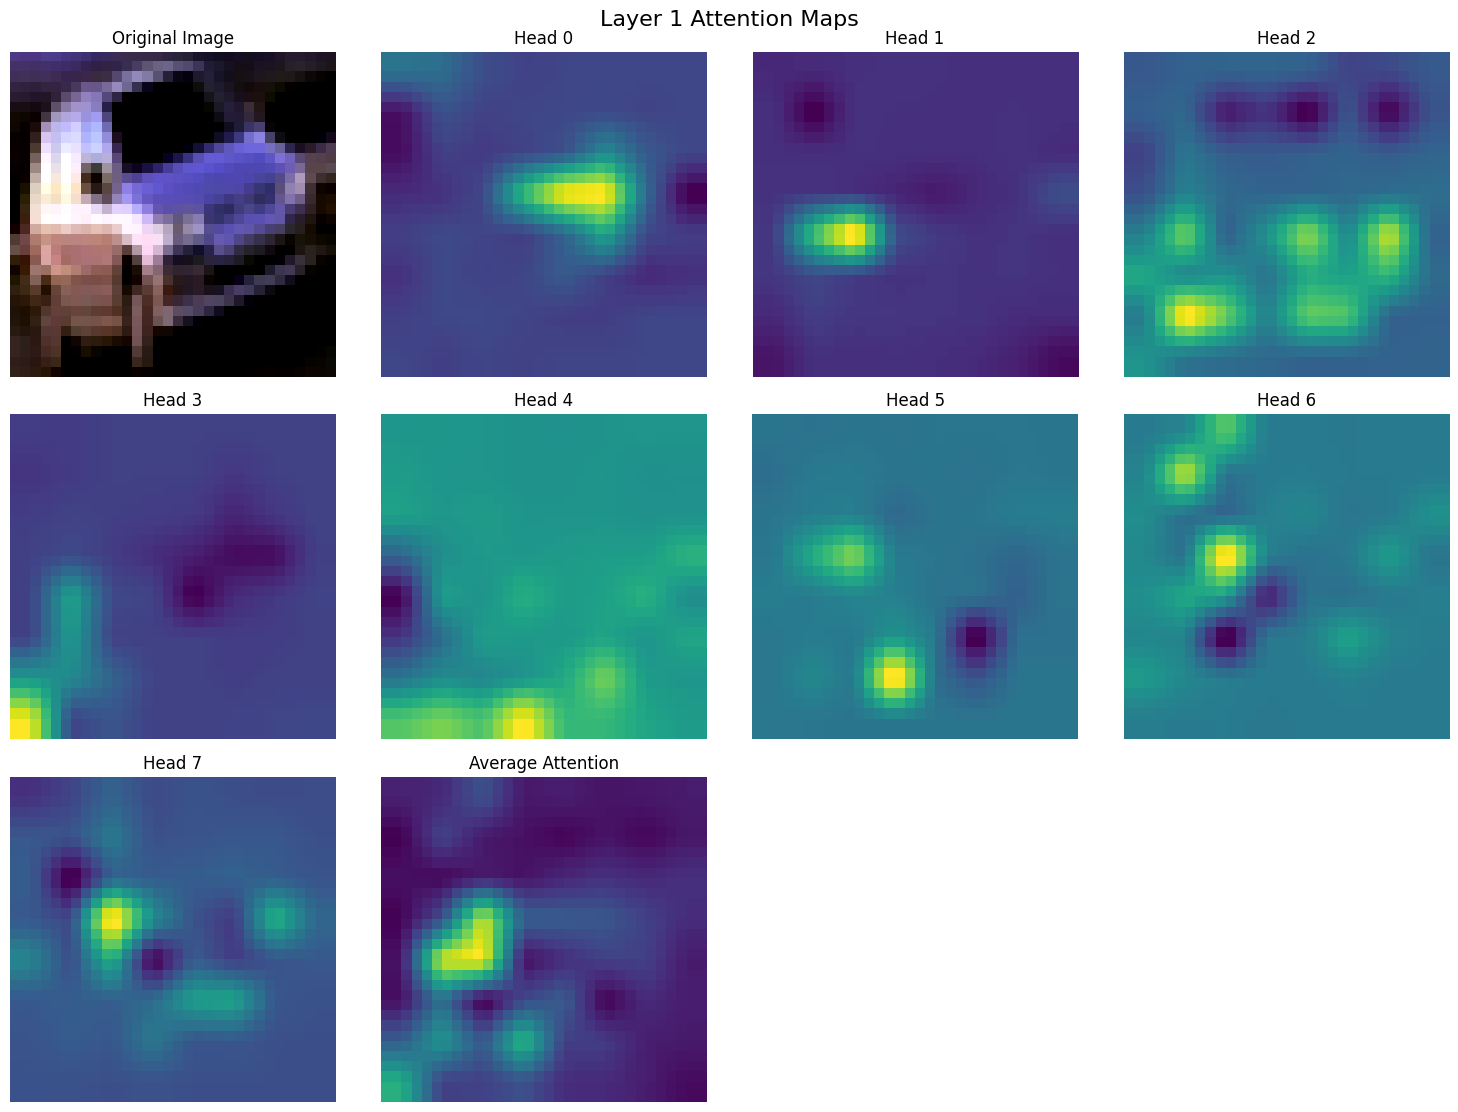

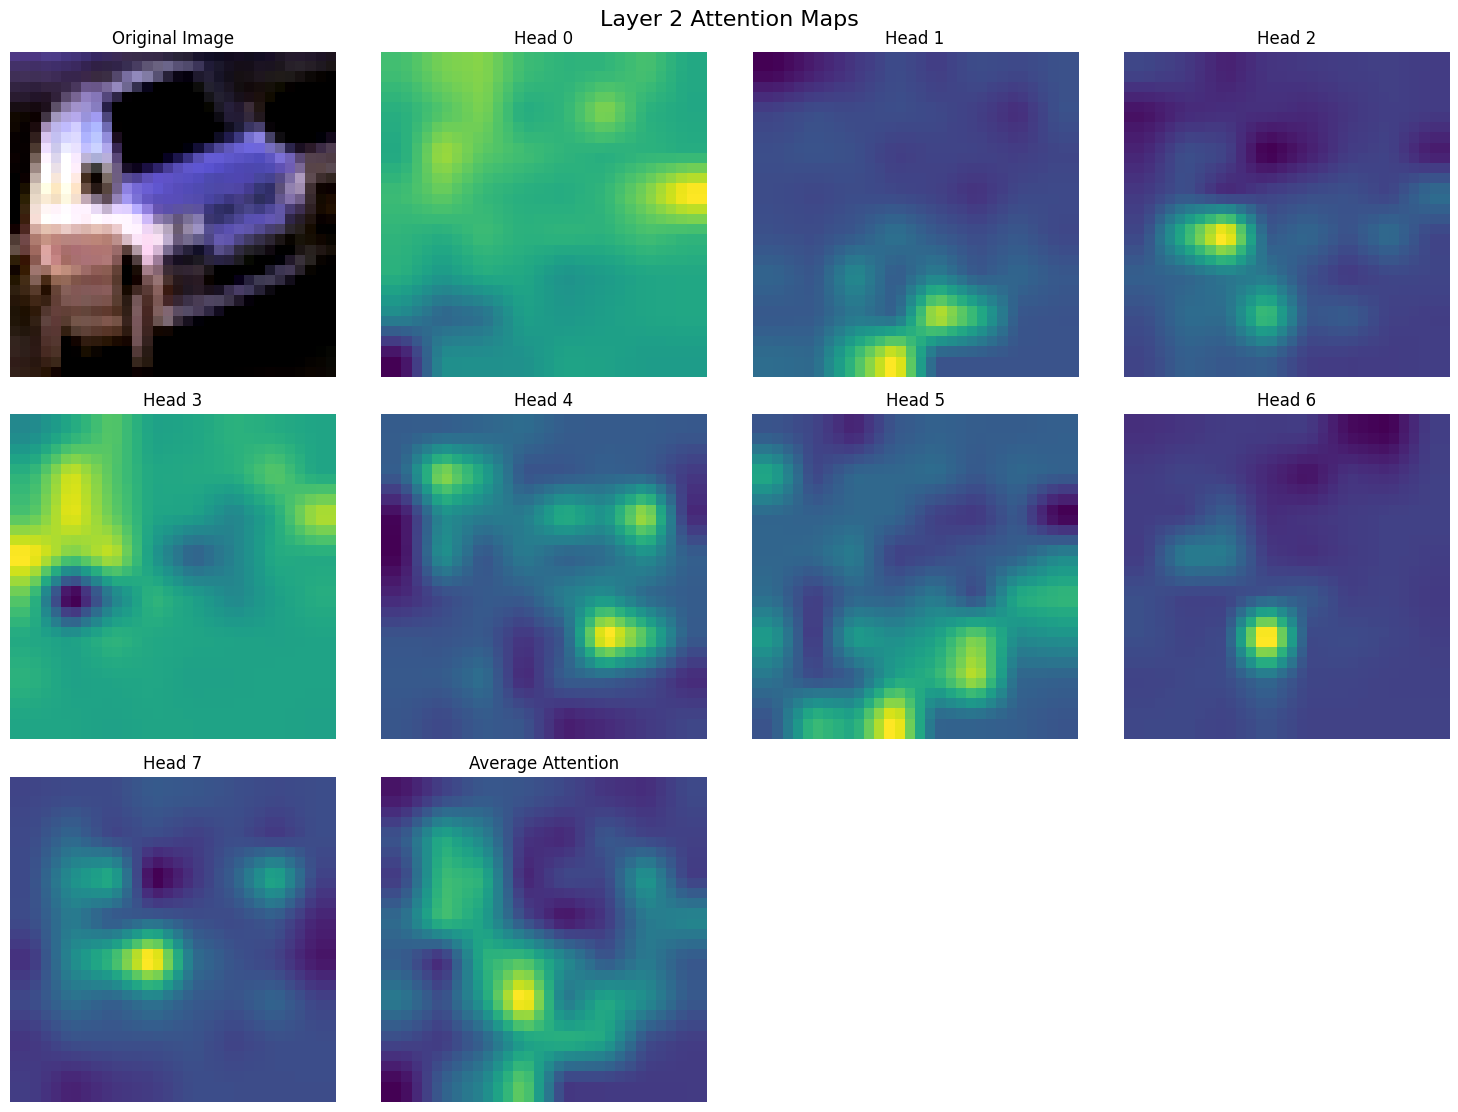

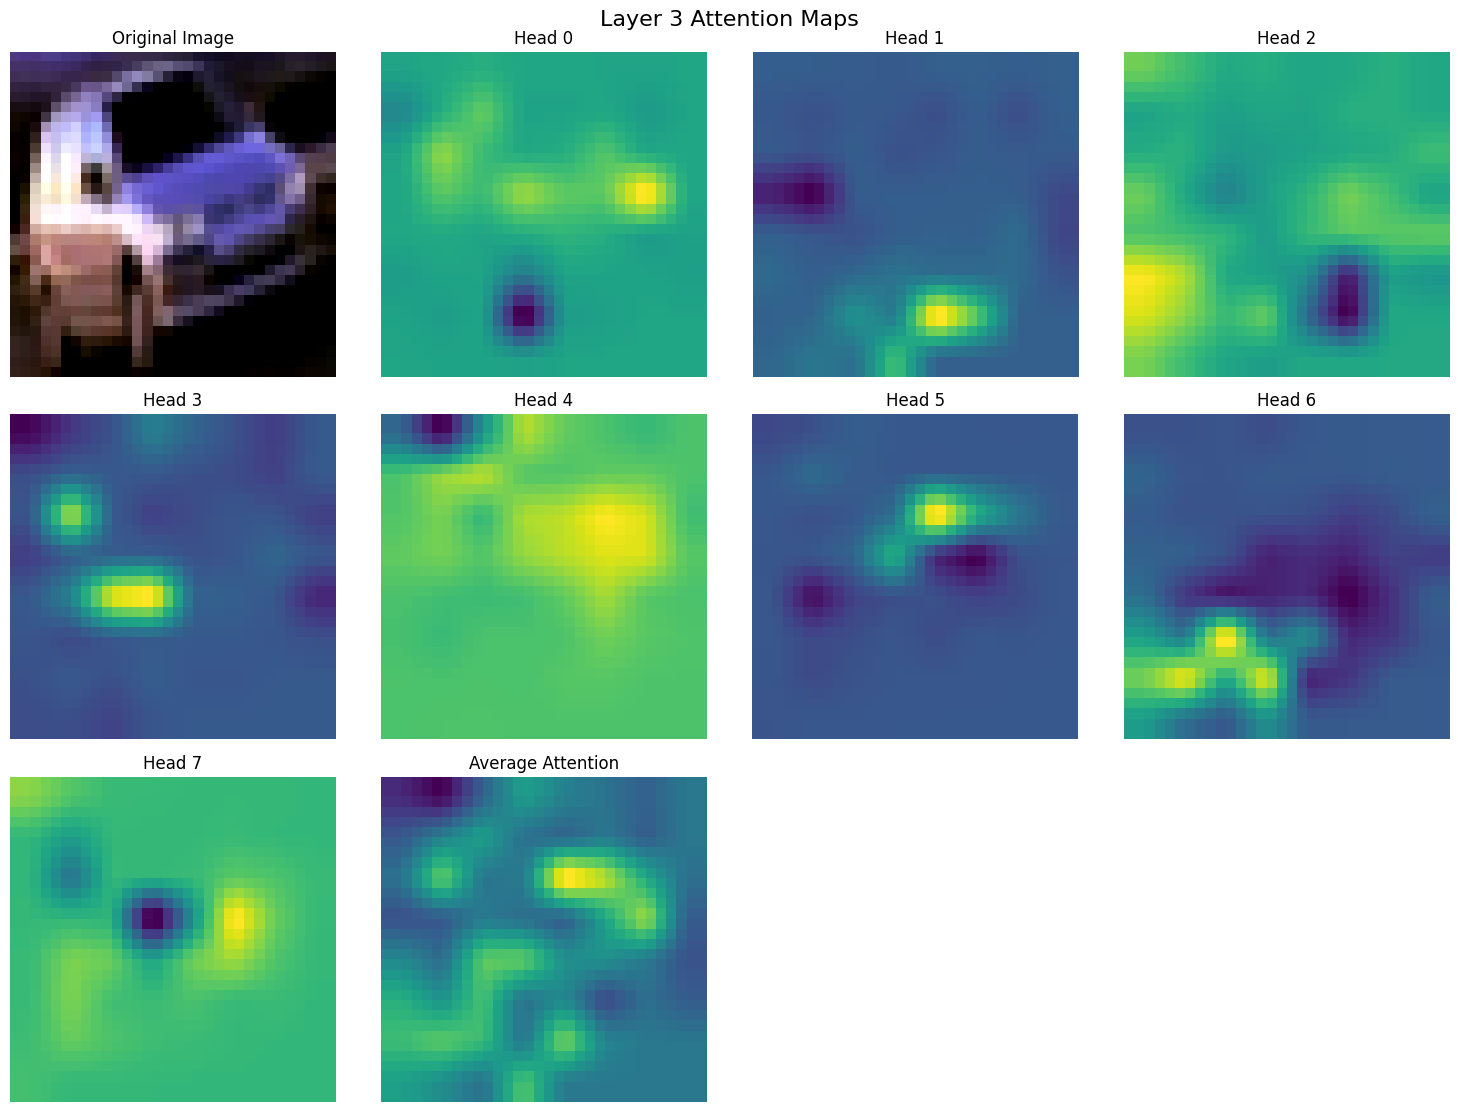

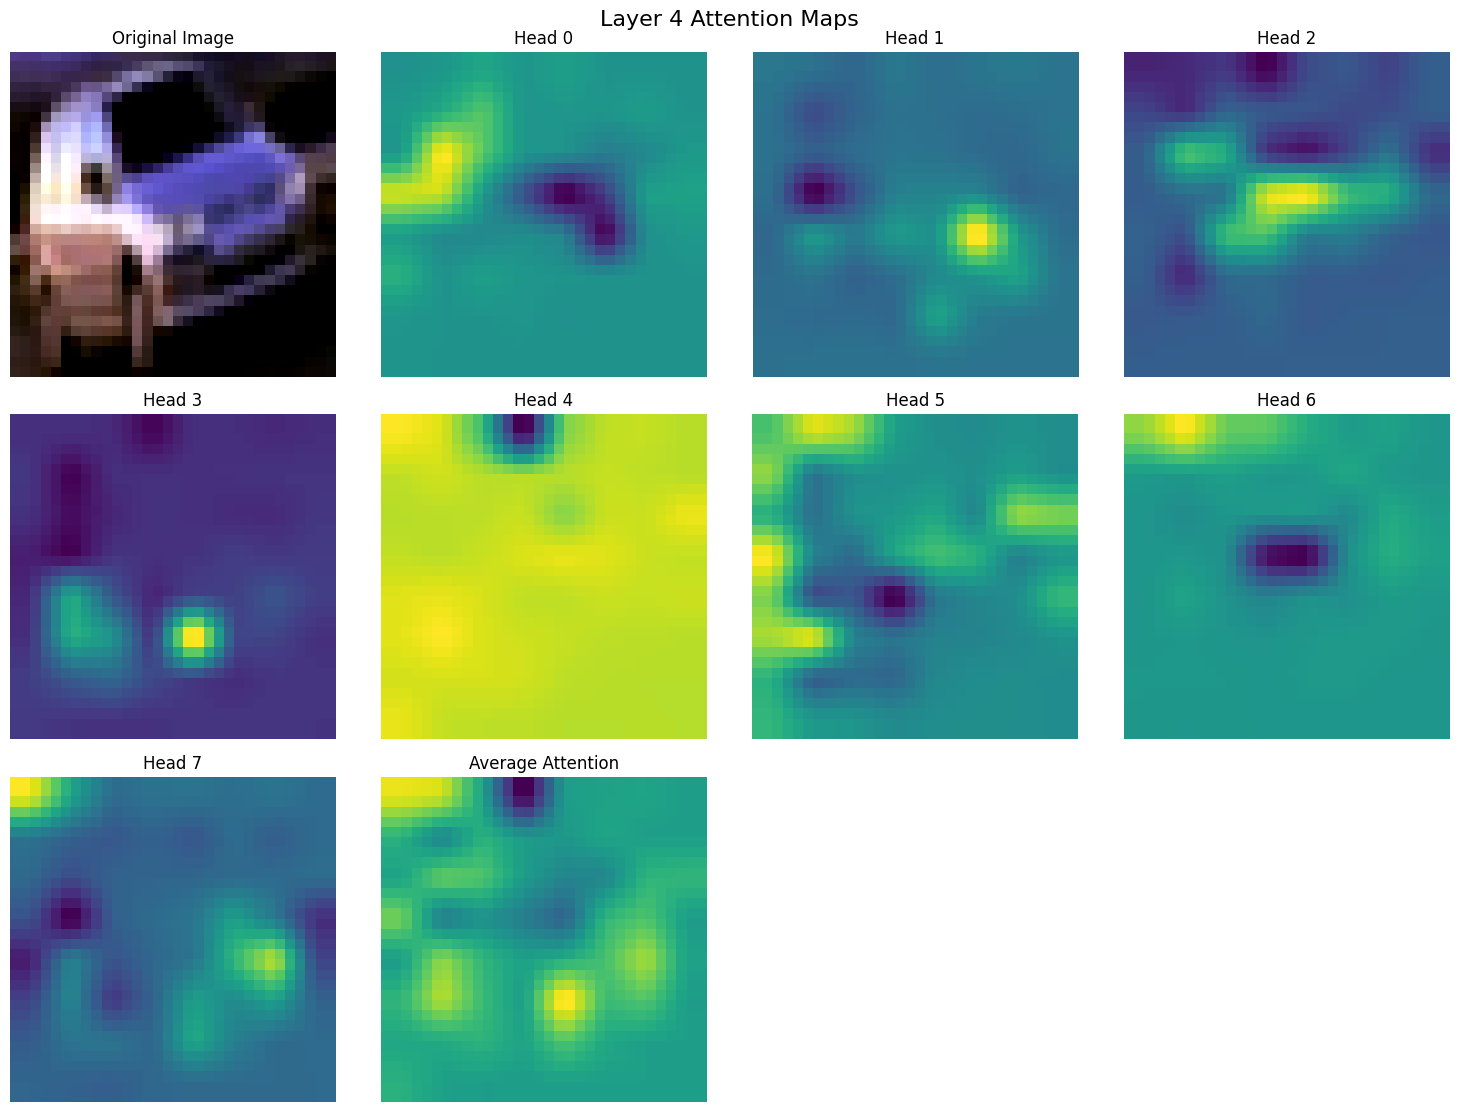

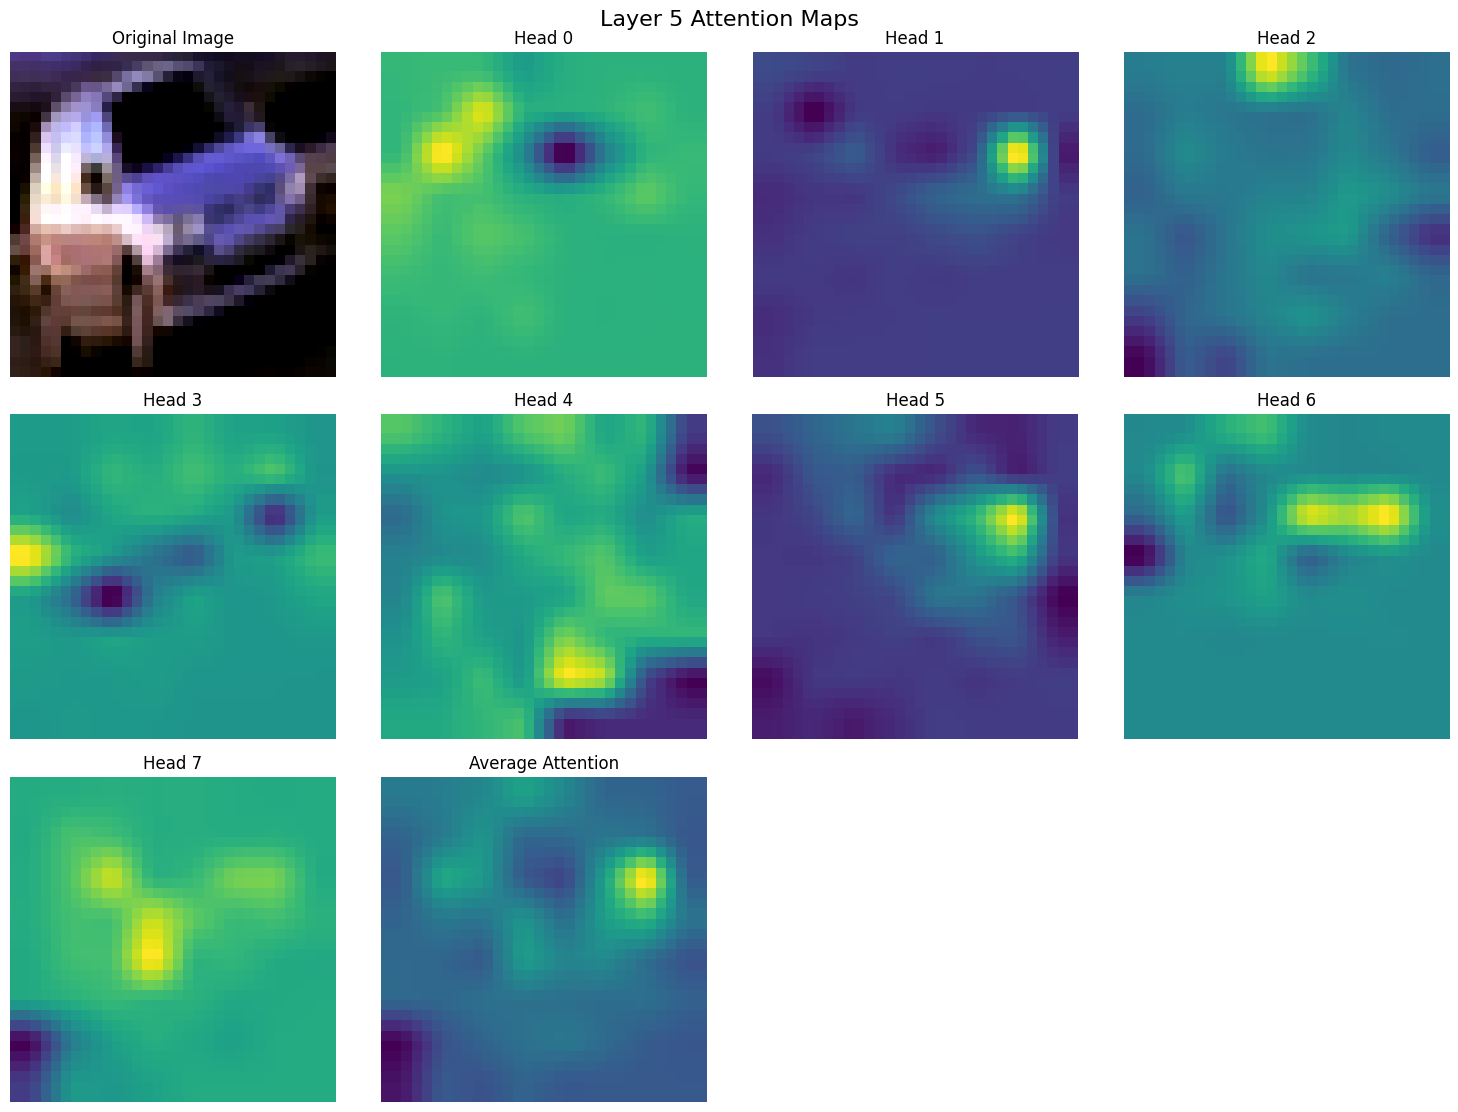

Attention Map using attention rollout:


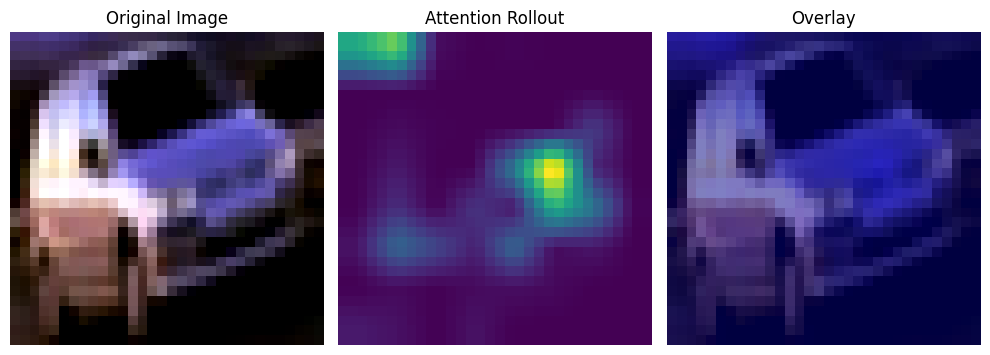

In [23]:
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

best_config = {'embed_dim': 384, 'num_layers': 6, 'mlp_ratio': 2, 'num_heads': 8}
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
run_visualizations('checkpoints/diffvit_best.pth', best_config, test_dataset)